In [22]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Import modules
import os 
import scipy.io
from scipy import stats
from __future__ import print_function
import pandas as pd

import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Data from .mat files

In [23]:
test=scipy.io.loadmat('adni_connectome_aparc_length.mat')
aparcl=np.array(test['connectome_aparc0x2Baseg_length'])
print(aparcl.shape)

test=scipy.io.loadmat('adni_connectome_aparc_count.mat')
aparcc=np.array(test['connectome_aparc0x2Baseg_count'])
print(aparcc.shape)

test=scipy.io.loadmat('adni_connectome_aparc2009_length.mat')
aparc2l=np.array(test['connectome_aparc0x2Ea2009s0x2Baseg_length'])
print(aparc2l.shape)

test=scipy.io.loadmat('adni_connectome_aparc2009_count.mat')
aparc2c=np.array(test['connectome_aparc0x2Ea2009s0x2Baseg_count'])
print(aparc2c.shape)



(84, 84, 179)
(84, 84, 179)
(164, 164, 179)
(164, 164, 179)


## Zeropad smaller data, reorganize shape

In [24]:
zeromatal=np.zeros([164,164,179])
zeromatac=np.zeros([164,164,179])

zeromatal[40:124,40:124,:]=aparcl
zeromatac[40:124,40:124,:]=aparcc

aparcl=zeromatal
aparcc=zeromatac

X=np.zeros([164,164,179,4])
X[:,:,:,0]=aparcl
X[:,:,:,1]=aparcc
X[:,:,:,2]=aparc2l
X[:,:,:,3]=aparc2c

X=X.transpose([2,0,1,3])
print(X.shape)

(179, 164, 164, 4)


## remove subjs without connectome data

In [25]:
data=pd.read_csv('adni_data_1_mor.csv',header=0)
data=np.array(data)
datasubjid=data[:,0]
print(datasubjid.shape)
matsubjid=pd.read_csv('adni_connectome_subjectlist.csv',header=0)
matsubjid=np.array(matsubjid)
print(matsubjid.shape)

filtindex=np.isin(datasubjid,matsubjid)
filtindex=filtindex.ravel()
labels=data[:,13]
y=labels[filtindex]
print(y.shape)


(201,)
(179, 1)
(179,)


## load labels, index data for all 6 types

In [26]:
# smi=1 , mci=2, ad=3

smiloc=np.asarray(np.where(y==1))
smiloc=np.ndarray.transpose(smiloc)
mciloc=np.asarray(np.where(y==2))
mciloc=np.ndarray.transpose(mciloc)
adloc=np.asarray(np.where(y==3))
adloc=np.ndarray.transpose(adloc)

test=scipy.io.loadmat('ADNI_morph_100.mat')
morphdata=np.array(test['M1_new'])

# can i just combine smiloc and mciloc for the morphdata?

#1v3, smi=0, ad=1
totalsize=len(smiloc)+len(adloc)
y_adsmi=np.zeros([totalsize])
X_adsmi=np.zeros([totalsize,164,164,4])
Xvar_adsmi=np.zeros([totalsize,morphdata.shape[1]])
for i in range(len(smiloc)):
    y_adsmi[i]=0
    X_adsmi[i,:,:,:]=X[smiloc[i],:,:,:]
    Xvar_adsmi[i,:]=morphdata[smiloc[i],:]
for j in range(len(adloc)):
    y_adsmi[len(smiloc)+j]=1
    X_adsmi[len(smiloc)+j,:,:,:]=X[adloc[j],:,:,:]
    Xvar_adsmi[len(smiloc)+j,:]=morphdata[adloc[j],:]
print(y_adsmi.shape)
print(X_adsmi.shape)

#1v2, smi=0, mci=1
totalsize=len(smiloc)+len(mciloc)
y_mcismi=np.zeros([totalsize])
X_mcismi=np.zeros([totalsize,164,164,4])
Xvar_mcismi=np.zeros([totalsize,morphdata.shape[1]])
for i in range(len(smiloc)):
    y_mcismi[i]=0
    X_mcismi[i,:,:,:]=X[smiloc[i],:,:,:]
    Xvar_mcismi[i,:]=morphdata[smiloc[i],:]
for j in range(len(mciloc)):
    y_mcismi[len(smiloc)+j]=1
    X_mcismi[len(smiloc)+j,:,:,:]=X[mciloc[j],:,:,:]
    Xvar_mcismi[len(smiloc)+j,:]=morphdata[mciloc[j],:]
print(y_mcismi.shape)
print(X_mcismi.shape)

#2v3, mci=0, ad=1
totalsize=len(mciloc)+len(adloc)
y_admci=np.zeros([totalsize])
X_admci=np.zeros([totalsize,164,164,4])
Xvar_admci=np.zeros([totalsize,morphdata.shape[1]])
for i in range(len(mciloc)):
    y_admci[i]=0
    X_admci[i,:,:,:]=X[mciloc[i],:,:,:]
    Xvar_admci[i,:]=morphdata[mciloc[i],:]
for j in range(len(adloc)):
    y_admci[len(mciloc)+j]=1
    X_admci[len(mciloc)+j,:,:,:]=X[adloc[j],:,:,:]
    Xvar_admci[len(mciloc)+j,:]=morphdata[adloc[j],:]
print(y_admci.shape)
print(X_admci.shape)


(119,)
(119, 164, 164, 4)
(131,)
(131, 164, 164, 4)
(108,)
(108, 164, 164, 4)


## Run CNN with 5fold Cross validation for AD_SMI

TRAIN: (94,) TEST: (25,)
(94, 100)
(25, 100)
Building Network Parameters: 
fc_units=[3000, 1000, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 9
epoch 1 
Best validation accuracy! iteration:9 accuracy: 72.0%
epoch 2 
Best validation accuracy! iteration:18 accuracy: 80.0%
epoch 3 
Best validation accuracy! iteration:27 accuracy: 84.0%
epoch 4 
Best validation accuracy! iteration:36 accuracy: 88.0%
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
Best validation accuracy! iteration:108 accuracy: 92.0%
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
epoch 21 
epoch 22 
epoch 23 
epoch 24 
epoch 25 
epoch 26 
epoch 27 
epoch 28 
epoch 29 
epoch 30 
epoch 31 
epoch 32 
epoch 33 
epoch 34 
epoch 35 
epoch 36 
epoch 37 
epoch 38 
epoch 39 
epoch 40 
epoch 41 
epoch 42 
epoch 43 
epoch 44 
epoch 45 
epoch 46 
epoch 47 
epoch 48 
epoch 49 
epoch 50 
epoch 51 
epoch 52 
epoch 53 
epoch 54 
epoch 55 
epoch 56

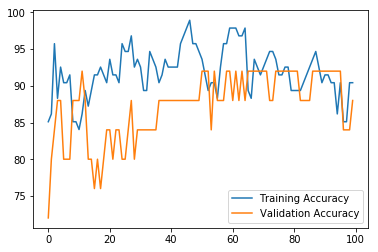

TRAIN: (95,) TEST: (24,)
(95, 100)
(24, 100)
Building Network Parameters: 
fc_units=[3000, 1000, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 9
epoch 1 
Best validation accuracy! iteration:9 accuracy: 87.5%
epoch 2 
epoch 3 
epoch 4 
epoch 5 
epoch 6 
epoch 7 
Best validation accuracy! iteration:63 accuracy: 91.66666666666667%
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
epoch 21 
epoch 22 
epoch 23 
epoch 24 
epoch 25 
epoch 26 
epoch 27 
epoch 28 
epoch 29 
epoch 30 
epoch 31 
epoch 32 
epoch 33 
epoch 34 
epoch 35 
epoch 36 
epoch 37 
epoch 38 
epoch 39 
epoch 40 
epoch 41 
epoch 42 
epoch 43 
epoch 44 
epoch 45 
epoch 46 
epoch 47 
epoch 48 
epoch 49 
epoch 50 
epoch 51 
epoch 52 
epoch 53 
epoch 54 
epoch 55 
epoch 56 
epoch 57 
epoch 58 
epoch 59 
epoch 60 
epoch 61 
epoch 62 
epoch 63 
epoch 64 
epoch 65 
epoch 66 
epoch 67 
epoch 68 
epoch 69 
epoch 70 
epoch 71 
e

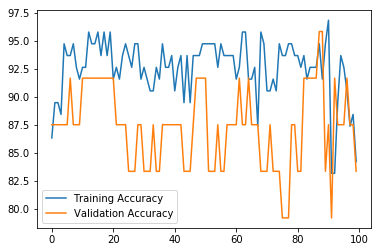

TRAIN: (95,) TEST: (24,)
(95, 100)
(24, 100)
Building Network Parameters: 
fc_units=[3000, 1000, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 9
epoch 1 
Best validation accuracy! iteration:9 accuracy: 75.0%
epoch 2 
epoch 3 
Best validation accuracy! iteration:27 accuracy: 79.16666666666667%
epoch 4 
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
epoch 21 
epoch 22 
epoch 23 
epoch 24 
epoch 25 
epoch 26 
epoch 27 
epoch 28 
epoch 29 
epoch 30 
epoch 31 
Best validation accuracy! iteration:279 accuracy: 83.33333333333333%
epoch 32 
epoch 33 
epoch 34 
epoch 35 
epoch 36 
epoch 37 
epoch 38 
epoch 39 
epoch 40 
epoch 41 
epoch 42 
epoch 43 
epoch 44 
epoch 45 
epoch 46 
epoch 47 
Best validation accuracy! iteration:423 accuracy: 87.5%
epoch 48 
epoch 49 
epoch 50 
epoch 51 
epoch 52 
epoch 53 
epoch 54 
epoch 55 
epoch 56 
epoch 57 
epoch 58 
epoch 

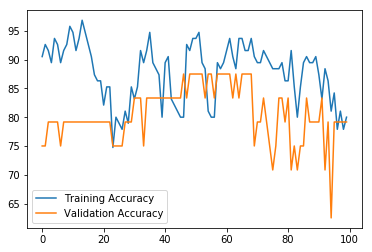

TRAIN: (96,) TEST: (23,)
(96, 100)
(23, 100)
Building Network Parameters: 
fc_units=[3000, 1000, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 9
epoch 1 
Best validation accuracy! iteration:9 accuracy: 86.95652173913044%
epoch 2 
Best validation accuracy! iteration:18 accuracy: 91.30434782608695%
epoch 3 
Best validation accuracy! iteration:27 accuracy: 95.65217391304348%
epoch 4 
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
epoch 21 
epoch 22 
epoch 23 
epoch 24 
epoch 25 
epoch 26 
epoch 27 
epoch 28 
epoch 29 
epoch 30 
epoch 31 
epoch 32 
epoch 33 
epoch 34 
epoch 35 
epoch 36 
epoch 37 
epoch 38 
epoch 39 
epoch 40 
epoch 41 
epoch 42 
epoch 43 
epoch 44 
epoch 45 
epoch 46 
epoch 47 
epoch 48 
epoch 49 
epoch 50 
epoch 51 
epoch 52 
epoch 53 
epoch 54 
epoch 55 
epoch 56 
epoch 57 
epoch 58 
epoch 59 
epoch 60 
epoch 61 
epoch 62 
epoch 63 


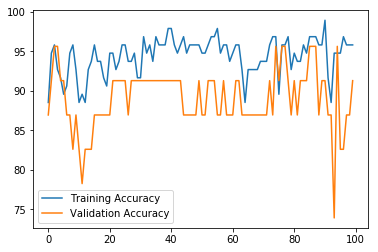

TRAIN: (96,) TEST: (23,)
(96, 100)
(23, 100)
Building Network Parameters: 
fc_units=[3000, 1000, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 9
epoch 1 
Best validation accuracy! iteration:9 accuracy: 78.26086956521739%
epoch 2 
epoch 3 
Best validation accuracy! iteration:27 accuracy: 82.6086956521739%
epoch 4 
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
epoch 21 
epoch 22 
epoch 23 
epoch 24 
epoch 25 
epoch 26 
epoch 27 
epoch 28 
epoch 29 
epoch 30 
epoch 31 
epoch 32 
epoch 33 
epoch 34 
epoch 35 
epoch 36 
epoch 37 
epoch 38 
epoch 39 
epoch 40 
epoch 41 
epoch 42 
epoch 43 
epoch 44 
epoch 45 
epoch 46 
epoch 47 
epoch 48 
epoch 49 
epoch 50 
epoch 51 
epoch 52 
epoch 53 
epoch 54 
epoch 55 
Best validation accuracy! iteration:495 accuracy: 86.95652173913044%
epoch 56 
epoch 57 
epoch 58 
epoch 59 
epoch 60 
epoch 61 
epoch 62 
epoch 63 


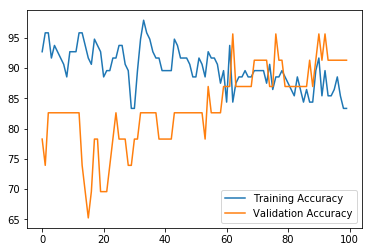

TRAIN: (94,) TEST: (25,)
(94, 100)
(25, 100)
Building Network Parameters: 
fc_units=[3000, 1000, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 9
epoch 1 
Best validation accuracy! iteration:9 accuracy: 88.0%
epoch 2 
Best validation accuracy! iteration:18 accuracy: 100.0%
epoch 3 
epoch 4 
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
epoch 21 
epoch 22 
epoch 23 
epoch 24 
epoch 25 
epoch 26 
epoch 27 
epoch 28 
epoch 29 
epoch 30 
epoch 31 
epoch 32 
epoch 33 
epoch 34 
epoch 35 
epoch 36 
epoch 37 
epoch 38 
epoch 39 
epoch 40 
epoch 41 
epoch 42 
epoch 43 
epoch 44 
epoch 45 
epoch 46 
epoch 47 
epoch 48 
epoch 49 
epoch 50 
epoch 51 
epoch 52 
epoch 53 
epoch 54 
epoch 55 
epoch 56 
epoch 57 
epoch 58 
epoch 59 
epoch 60 
epoch 61 
epoch 62 
epoch 63 
epoch 64 
epoch 65 
epoch 66 
epoch 67 
epoch 68 
epoch 69 
epoch 70 
epoch 71 
epoch 72 
epo

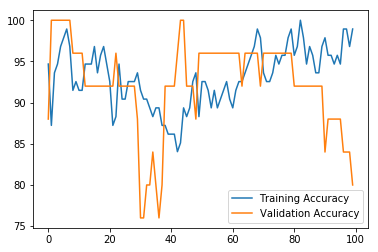

TRAIN: (95,) TEST: (24,)
(95, 100)
(24, 100)
Building Network Parameters: 
fc_units=[3000, 1000, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 9
epoch 1 
Best validation accuracy! iteration:9 accuracy: 79.16666666666667%
epoch 2 
epoch 3 
epoch 4 
Best validation accuracy! iteration:36 accuracy: 83.33333333333333%
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
epoch 21 
epoch 22 
epoch 23 
epoch 24 
epoch 25 
epoch 26 
epoch 27 
epoch 28 
epoch 29 
epoch 30 
epoch 31 
epoch 32 
epoch 33 
epoch 34 
epoch 35 
epoch 36 
epoch 37 
epoch 38 
epoch 39 
epoch 40 
epoch 41 
epoch 42 
epoch 43 
epoch 44 
epoch 45 
epoch 46 
epoch 47 
epoch 48 
epoch 49 
epoch 50 
epoch 51 
epoch 52 
epoch 53 
epoch 54 
epoch 55 
epoch 56 
epoch 57 
epoch 58 
epoch 59 
epoch 60 
epoch 61 
epoch 62 
epoch 63 
epoch 64 
epoch 65 
epoch 66 
epoch 67 
epoch 68 
epoch 69 
epoch 70

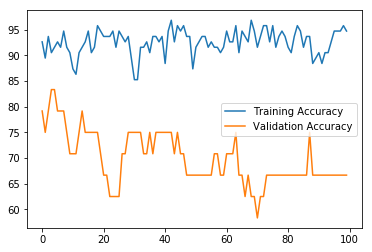

TRAIN: (95,) TEST: (24,)
(95, 100)
(24, 100)
Building Network Parameters: 
fc_units=[3000, 1000, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 9
epoch 1 
Best validation accuracy! iteration:9 accuracy: 79.16666666666667%
epoch 2 
epoch 3 
Best validation accuracy! iteration:27 accuracy: 83.33333333333333%
epoch 4 
epoch 5 
Best validation accuracy! iteration:45 accuracy: 91.66666666666667%
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
epoch 21 
epoch 22 
epoch 23 
epoch 24 
epoch 25 
epoch 26 
epoch 27 
epoch 28 
epoch 29 
epoch 30 
epoch 31 
epoch 32 
epoch 33 
epoch 34 
epoch 35 
epoch 36 
epoch 37 
epoch 38 
epoch 39 
epoch 40 
epoch 41 
epoch 42 
epoch 43 
epoch 44 
epoch 45 
epoch 46 
epoch 47 
epoch 48 
epoch 49 
epoch 50 
epoch 51 
epoch 52 
epoch 53 
epoch 54 
epoch 55 
epoch 56 
Best validation accuracy! iteration:504 accuracy: 95.83333333333333%
e

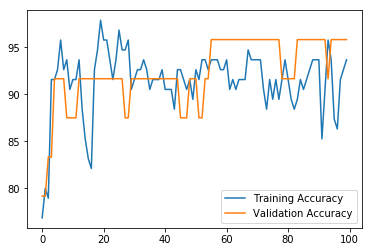

TRAIN: (96,) TEST: (23,)
(96, 100)
(23, 100)
Building Network Parameters: 
fc_units=[3000, 1000, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 9
epoch 1 
Best validation accuracy! iteration:9 accuracy: 82.6086956521739%
epoch 2 
Best validation accuracy! iteration:18 accuracy: 86.95652173913044%
epoch 3 
epoch 4 
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
epoch 21 
Best validation accuracy! iteration:189 accuracy: 91.30434782608695%
epoch 22 
epoch 23 
epoch 24 
epoch 25 
epoch 26 
epoch 27 
epoch 28 
epoch 29 
epoch 30 
epoch 31 
epoch 32 
epoch 33 
epoch 34 
epoch 35 
epoch 36 
epoch 37 
epoch 38 
epoch 39 
epoch 40 
epoch 41 
epoch 42 
epoch 43 
epoch 44 
epoch 45 
epoch 46 
epoch 47 
epoch 48 
epoch 49 
epoch 50 
epoch 51 
epoch 52 
epoch 53 
epoch 54 
epoch 55 
epoch 56 
epoch 57 
epoch 58 
epoch 59 
epoch 60 
epoch 61 
epoch 62 
epoch 63 


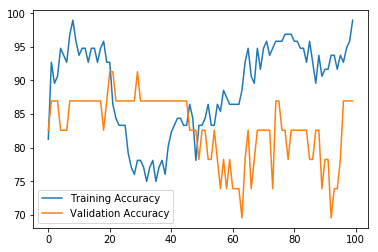

TRAIN: (96,) TEST: (23,)
(96, 100)
(23, 100)
Building Network Parameters: 
fc_units=[3000, 1000, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 9
epoch 1 
Best validation accuracy! iteration:9 accuracy: 86.95652173913044%
epoch 2 
epoch 3 
epoch 4 
Best validation accuracy! iteration:36 accuracy: 91.30434782608695%
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
epoch 21 
epoch 22 
epoch 23 
epoch 24 
epoch 25 
epoch 26 
epoch 27 
epoch 28 
epoch 29 
epoch 30 
Best validation accuracy! iteration:270 accuracy: 95.65217391304348%
epoch 31 
epoch 32 
epoch 33 
epoch 34 
epoch 35 
epoch 36 
epoch 37 
epoch 38 
epoch 39 
epoch 40 
epoch 41 
epoch 42 
epoch 43 
epoch 44 
epoch 45 
epoch 46 
epoch 47 
epoch 48 
epoch 49 
epoch 50 
epoch 51 
epoch 52 
epoch 53 
epoch 54 
epoch 55 
epoch 56 
epoch 57 
epoch 58 
epoch 59 
epoch 60 
epoch 61 
Best validation acc

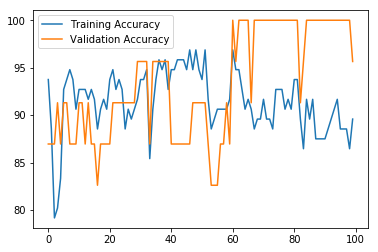

TRAIN: (94,) TEST: (25,)
(94, 100)
(25, 100)
Building Network Parameters: 
fc_units=[3000, 1000, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 9
epoch 1 
Best validation accuracy! iteration:9 accuracy: 68.0%
epoch 2 
epoch 3 
epoch 4 
Best validation accuracy! iteration:36 accuracy: 76.0%
epoch 5 
Best validation accuracy! iteration:45 accuracy: 84.0%
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
Best validation accuracy! iteration:99 accuracy: 88.0%
epoch 12 
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
epoch 21 
epoch 22 
epoch 23 
epoch 24 
epoch 25 
epoch 26 
epoch 27 
epoch 28 
epoch 29 
epoch 30 
epoch 31 
epoch 32 
epoch 33 
epoch 34 
epoch 35 
epoch 36 
epoch 37 
epoch 38 
epoch 39 
epoch 40 
epoch 41 
epoch 42 
epoch 43 
epoch 44 
epoch 45 
epoch 46 
epoch 47 
epoch 48 
epoch 49 
epoch 50 
epoch 51 
epoch 52 
epoch 53 
epoch 54 
epoch 55 
epoch 56 
epoch 57 
epoch 58 
epoch 59 
epoch 60 
epoch 61 
epoc

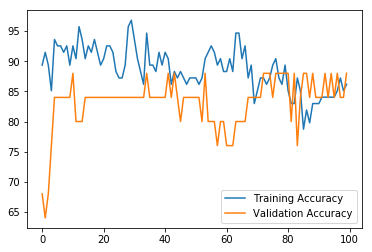

TRAIN: (95,) TEST: (24,)
(95, 100)
(24, 100)
Building Network Parameters: 
fc_units=[3000, 1000, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 9
epoch 1 
Best validation accuracy! iteration:9 accuracy: 83.33333333333333%
epoch 2 
Best validation accuracy! iteration:18 accuracy: 87.5%
epoch 3 
epoch 4 
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
epoch 21 
epoch 22 
epoch 23 
epoch 24 
epoch 25 
epoch 26 
epoch 27 
epoch 28 
epoch 29 
epoch 30 
epoch 31 
epoch 32 
epoch 33 
epoch 34 
epoch 35 
epoch 36 
epoch 37 
epoch 38 
epoch 39 
epoch 40 
epoch 41 
epoch 42 
epoch 43 
epoch 44 
epoch 45 
epoch 46 
epoch 47 
epoch 48 
epoch 49 
epoch 50 
epoch 51 
epoch 52 
epoch 53 
epoch 54 
epoch 55 
epoch 56 
epoch 57 
epoch 58 
epoch 59 
epoch 60 
epoch 61 
epoch 62 
epoch 63 
epoch 64 
epoch 65 
epoch 66 
epoch 67 
epoch 68 
epoch 69 
epoch 70 
epoch 71 
e

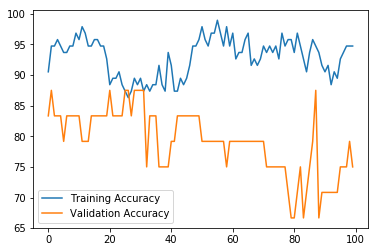

TRAIN: (95,) TEST: (24,)
(95, 100)
(24, 100)
Building Network Parameters: 
fc_units=[3000, 1000, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 9
epoch 1 
Best validation accuracy! iteration:9 accuracy: 75.0%
epoch 2 
epoch 3 
epoch 4 
Best validation accuracy! iteration:36 accuracy: 83.33333333333333%
epoch 5 
Best validation accuracy! iteration:45 accuracy: 87.5%
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
Best validation accuracy! iteration:117 accuracy: 91.66666666666667%
epoch 14 
epoch 15 
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
epoch 21 
epoch 22 
epoch 23 
epoch 24 
epoch 25 
epoch 26 
epoch 27 
epoch 28 
epoch 29 
epoch 30 
epoch 31 
epoch 32 
epoch 33 
epoch 34 
epoch 35 
epoch 36 
epoch 37 
epoch 38 
epoch 39 
epoch 40 
epoch 41 
epoch 42 
epoch 43 
epoch 44 
epoch 45 
epoch 46 
epoch 47 
epoch 48 
epoch 49 
epoch 50 
epoch 51 
epoch 52 
epoch 53 
epoch 54 
epoch 55 
epoch 56 
epoch 57 
epoch 58 
epoch 5

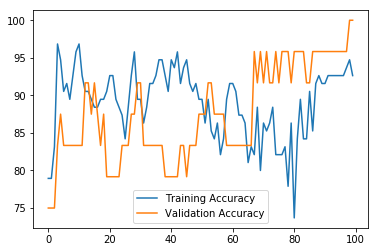

TRAIN: (96,) TEST: (23,)
(96, 100)
(23, 100)
Building Network Parameters: 
fc_units=[3000, 1000, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 9
epoch 1 
Best validation accuracy! iteration:9 accuracy: 95.65217391304348%
epoch 2 
epoch 3 
epoch 4 
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
epoch 21 
epoch 22 
epoch 23 
epoch 24 
epoch 25 
epoch 26 
epoch 27 
epoch 28 
epoch 29 
epoch 30 
epoch 31 
epoch 32 
epoch 33 
epoch 34 
epoch 35 
epoch 36 
epoch 37 
epoch 38 
epoch 39 
epoch 40 
epoch 41 
epoch 42 
epoch 43 
epoch 44 
epoch 45 
epoch 46 
epoch 47 
epoch 48 
epoch 49 
epoch 50 
epoch 51 
epoch 52 
epoch 53 
epoch 54 
epoch 55 
epoch 56 
epoch 57 
epoch 58 
epoch 59 
Best validation accuracy! iteration:531 accuracy: 100.0%
epoch 60 
epoch 61 
epoch 62 
epoch 63 
epoch 64 
epoch 65 
epoch 66 
epoch 67 
epoch 68 
epoch 69 
epoch 70 
epoch 71 

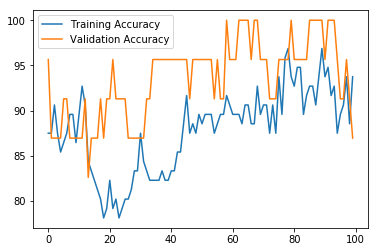

TRAIN: (96,) TEST: (23,)
(96, 100)
(23, 100)
Building Network Parameters: 
fc_units=[3000, 1000, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 9
epoch 1 
Best validation accuracy! iteration:9 accuracy: 65.21739130434783%
epoch 2 
epoch 3 
Best validation accuracy! iteration:27 accuracy: 69.56521739130434%
epoch 4 
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
Best validation accuracy! iteration:99 accuracy: 73.91304347826087%
epoch 12 
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch 17 
epoch 18 
epoch 19 
Best validation accuracy! iteration:171 accuracy: 78.26086956521739%
epoch 20 
Best validation accuracy! iteration:180 accuracy: 86.95652173913044%
epoch 21 
Best validation accuracy! iteration:189 accuracy: 91.30434782608695%
epoch 22 
epoch 23 
epoch 24 
epoch 25 
epoch 26 
epoch 27 
epoch 28 
epoch 29 
epoch 30 
epoch 31 
epoch 32 
epoch 33 
epoch 34 
epoch 35 
epoch 36 
epoch 37 
epoch 38 
epoch 39 
epoch 40 
epoch 41 
epoch 42 
epo

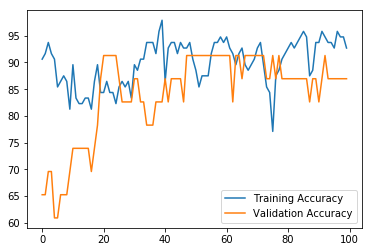

TRAIN: (94,) TEST: (25,)
(94, 100)
(25, 100)
Building Network Parameters: 
fc_units=[3000, 1000, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 9
epoch 1 
Best validation accuracy! iteration:9 accuracy: 76.0%
epoch 2 
Best validation accuracy! iteration:18 accuracy: 84.0%
epoch 3 
epoch 4 
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
epoch 21 
epoch 22 
epoch 23 
epoch 24 
epoch 25 
epoch 26 
epoch 27 
epoch 28 
epoch 29 
epoch 30 
epoch 31 
epoch 32 
epoch 33 
epoch 34 
epoch 35 
epoch 36 
epoch 37 
epoch 38 
epoch 39 
epoch 40 
epoch 41 
epoch 42 
epoch 43 
epoch 44 
epoch 45 
epoch 46 
epoch 47 
epoch 48 
epoch 49 
epoch 50 
epoch 51 
epoch 52 
epoch 53 
epoch 54 
epoch 55 
epoch 56 
epoch 57 
epoch 58 
epoch 59 
epoch 60 
epoch 61 
epoch 62 
epoch 63 
epoch 64 
epoch 65 
epoch 66 
epoch 67 
epoch 68 
epoch 69 
epoch 70 
epoch 71 
epoch 72 
epoc

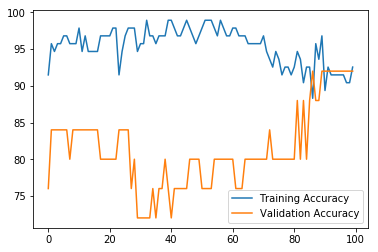

TRAIN: (95,) TEST: (24,)
(95, 100)
(24, 100)
Building Network Parameters: 
fc_units=[3000, 1000, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 9
epoch 1 
Best validation accuracy! iteration:9 accuracy: 79.16666666666667%
epoch 2 
epoch 3 
epoch 4 
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
Best validation accuracy! iteration:108 accuracy: 83.33333333333333%
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
epoch 21 
epoch 22 
epoch 23 
epoch 24 
epoch 25 
epoch 26 
epoch 27 
epoch 28 
epoch 29 
epoch 30 
epoch 31 
epoch 32 
epoch 33 
epoch 34 
epoch 35 
epoch 36 
epoch 37 
epoch 38 
epoch 39 
epoch 40 
epoch 41 
epoch 42 
epoch 43 
epoch 44 
epoch 45 
epoch 46 
Best validation accuracy! iteration:414 accuracy: 87.5%
epoch 47 
epoch 48 
epoch 49 
epoch 50 
epoch 51 
epoch 52 
epoch 53 
epoch 54 
epoch 55 
epoch 56 
epoch 57 
epoch 58 
epoch 59 
epoch 60 
epoch 61 
epoch 62 
epoch 63 
epoch 64 
e

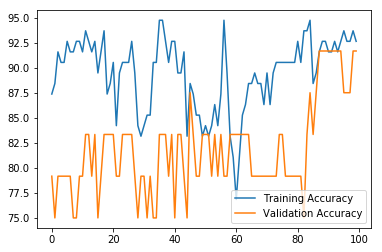

TRAIN: (95,) TEST: (24,)
(95, 100)
(24, 100)
Building Network Parameters: 
fc_units=[3000, 1000, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 9
epoch 1 
Best validation accuracy! iteration:9 accuracy: 83.33333333333333%
epoch 2 
Best validation accuracy! iteration:18 accuracy: 91.66666666666667%
epoch 3 
epoch 4 
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
Best validation accuracy! iteration:117 accuracy: 95.83333333333333%
epoch 14 
epoch 15 
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
epoch 21 
epoch 22 
epoch 23 
epoch 24 
epoch 25 
epoch 26 
epoch 27 
epoch 28 
epoch 29 
epoch 30 
epoch 31 
epoch 32 
epoch 33 
epoch 34 
epoch 35 
epoch 36 
epoch 37 
epoch 38 
epoch 39 
epoch 40 
epoch 41 
epoch 42 
epoch 43 
epoch 44 
epoch 45 
epoch 46 
epoch 47 
epoch 48 
epoch 49 
epoch 50 
epoch 51 
epoch 52 
epoch 53 
epoch 54 
epoch 55 
epoch 56 
epoch 57 
epoch 58 
epoch 59 
epoch 60 
epoch 61 
epoch 62 
epoch 63 

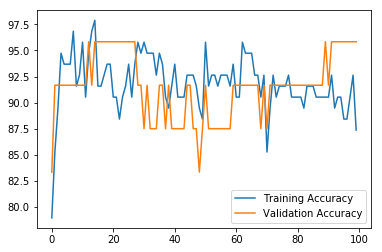

TRAIN: (96,) TEST: (23,)
(96, 100)
(23, 100)
Building Network Parameters: 
fc_units=[3000, 1000, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 9
epoch 1 
Best validation accuracy! iteration:9 accuracy: 86.95652173913044%
epoch 2 
Best validation accuracy! iteration:18 accuracy: 91.30434782608695%
epoch 3 
epoch 4 
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
epoch 21 
epoch 22 
epoch 23 
epoch 24 
epoch 25 
epoch 26 
epoch 27 
epoch 28 
epoch 29 
epoch 30 
epoch 31 
epoch 32 
epoch 33 
epoch 34 
epoch 35 
epoch 36 
epoch 37 
epoch 38 
epoch 39 
epoch 40 
epoch 41 
epoch 42 
epoch 43 
epoch 44 
epoch 45 
epoch 46 
epoch 47 
epoch 48 
epoch 49 
epoch 50 
epoch 51 
epoch 52 
epoch 53 
epoch 54 
epoch 55 
epoch 56 
epoch 57 
epoch 58 
epoch 59 
epoch 60 
epoch 61 
epoch 62 
epoch 63 
epoch 64 
epoch 65 
epoch 66 
epoch 67 
epoch 68 
epoch 69 
epoch 70

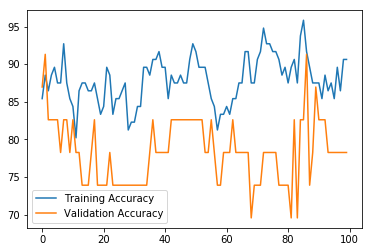

TRAIN: (96,) TEST: (23,)
(96, 100)
(23, 100)
Building Network Parameters: 
fc_units=[3000, 1000, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 9
epoch 1 
Best validation accuracy! iteration:9 accuracy: 73.91304347826087%
epoch 2 
Best validation accuracy! iteration:18 accuracy: 82.6086956521739%
epoch 3 
Best validation accuracy! iteration:27 accuracy: 86.95652173913044%
epoch 4 
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
epoch 21 
epoch 22 
epoch 23 
epoch 24 
epoch 25 
epoch 26 
epoch 27 
epoch 28 
epoch 29 
epoch 30 
epoch 31 
epoch 32 
epoch 33 
epoch 34 
epoch 35 
epoch 36 
epoch 37 
epoch 38 
epoch 39 
epoch 40 
epoch 41 
epoch 42 
epoch 43 
epoch 44 
epoch 45 
epoch 46 
epoch 47 
epoch 48 
epoch 49 
epoch 50 
epoch 51 
epoch 52 
epoch 53 
epoch 54 
epoch 55 
epoch 56 
epoch 57 
epoch 58 
epoch 59 
epoch 60 
epoch 61 
epoch 62 
epoch 63 
e

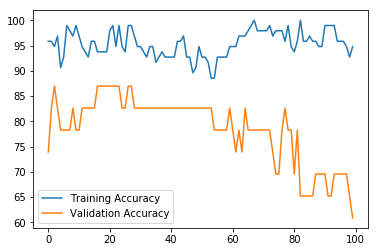

TRAIN: (94,) TEST: (25,)
(94, 100)
(25, 100)
Building Network Parameters: 
fc_units=[3000, 1000, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 9
epoch 1 
Best validation accuracy! iteration:9 accuracy: 64.0%
epoch 2 
Best validation accuracy! iteration:18 accuracy: 72.0%
epoch 3 
epoch 4 
epoch 5 
epoch 6 
Best validation accuracy! iteration:54 accuracy: 76.0%
epoch 7 
epoch 8 
Best validation accuracy! iteration:72 accuracy: 80.0%
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
Best validation accuracy! iteration:135 accuracy: 84.0%
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
epoch 21 
epoch 22 
epoch 23 
epoch 24 
epoch 25 
epoch 26 
epoch 27 
epoch 28 
epoch 29 
Best validation accuracy! iteration:261 accuracy: 88.0%
epoch 30 
epoch 31 
epoch 32 
epoch 33 
epoch 34 
epoch 35 
epoch 36 
epoch 37 
epoch 38 
epoch 39 
epoch 40 
epoch 41 
epoch 42 
epoch 43 
epoch 44 
epoch 45 
epoch 46 
epoch 47 
epoch 48 
epoch 49 
epoch 50 
ep

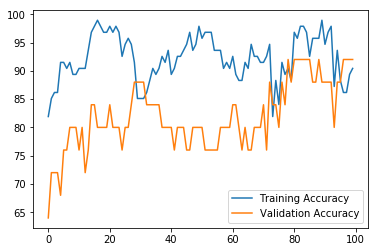

TRAIN: (95,) TEST: (24,)
(95, 100)
(24, 100)
Building Network Parameters: 
fc_units=[3000, 1000, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 9
epoch 1 
Best validation accuracy! iteration:9 accuracy: 79.16666666666667%
epoch 2 
epoch 3 
epoch 4 
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
epoch 21 
epoch 22 
epoch 23 
epoch 24 
epoch 25 
epoch 26 
epoch 27 
Best validation accuracy! iteration:243 accuracy: 83.33333333333333%
epoch 28 
epoch 29 
epoch 30 
epoch 31 
epoch 32 
epoch 33 
epoch 34 
epoch 35 
epoch 36 
epoch 37 
epoch 38 
epoch 39 
epoch 40 
epoch 41 
epoch 42 
epoch 43 
epoch 44 
epoch 45 
epoch 46 
epoch 47 
epoch 48 
epoch 49 
epoch 50 
epoch 51 
epoch 52 
epoch 53 
epoch 54 
epoch 55 
epoch 56 
epoch 57 
epoch 58 
epoch 59 
epoch 60 
epoch 61 
epoch 62 
epoch 63 
epoch 64 
epoch 65 
epoch 66 
epoch 67 
epoch 68 
epoch 69 
epoch 7

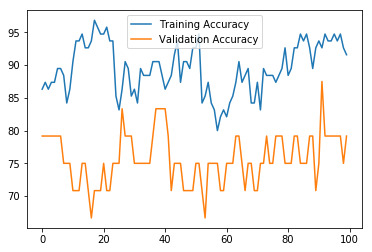

TRAIN: (95,) TEST: (24,)
(95, 100)
(24, 100)
Building Network Parameters: 
fc_units=[3000, 1000, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 9
epoch 1 
Best validation accuracy! iteration:9 accuracy: 75.0%
epoch 2 
Best validation accuracy! iteration:18 accuracy: 83.33333333333333%
epoch 3 
epoch 4 
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
Best validation accuracy! iteration:180 accuracy: 87.5%
epoch 21 
epoch 22 
epoch 23 
epoch 24 
epoch 25 
epoch 26 
epoch 27 
epoch 28 
epoch 29 
epoch 30 
epoch 31 
epoch 32 
epoch 33 
epoch 34 
epoch 35 
epoch 36 
epoch 37 
epoch 38 
epoch 39 
epoch 40 
epoch 41 
epoch 42 
epoch 43 
epoch 44 
epoch 45 
epoch 46 
epoch 47 
epoch 48 
epoch 49 
epoch 50 
epoch 51 
epoch 52 
epoch 53 
epoch 54 
epoch 55 
epoch 56 
epoch 57 
epoch 58 
epoch 59 
epoch 60 
epoch 61 
epoch 62 
epoch 63 
epoch 64 
epoch 65 
epoch

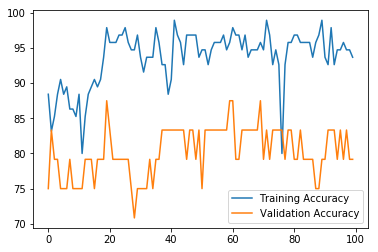

TRAIN: (96,) TEST: (23,)
(96, 100)
(23, 100)
Building Network Parameters: 
fc_units=[3000, 1000, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 9
epoch 1 
Best validation accuracy! iteration:9 accuracy: 65.21739130434783%
epoch 2 
Best validation accuracy! iteration:18 accuracy: 73.91304347826087%
epoch 3 
epoch 4 
Best validation accuracy! iteration:36 accuracy: 78.26086956521739%
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
Best validation accuracy! iteration:81 accuracy: 82.6086956521739%
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
epoch 21 
epoch 22 
epoch 23 
epoch 24 
epoch 25 
epoch 26 
epoch 27 
epoch 28 
epoch 29 
epoch 30 
epoch 31 
epoch 32 
Best validation accuracy! iteration:288 accuracy: 86.95652173913044%
epoch 33 
epoch 34 
epoch 35 
epoch 36 
epoch 37 
epoch 38 
epoch 39 
epoch 40 
epoch 41 
epoch 42 
epoch 43 
epoch 44 
epoch 45 
epoch 46 
epoch 47 
epoch 48 
epoch 49 
epoc

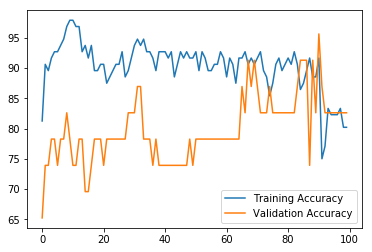

TRAIN: (96,) TEST: (23,)
(96, 100)
(23, 100)
Building Network Parameters: 
fc_units=[3000, 1000, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 9
epoch 1 
Best validation accuracy! iteration:9 accuracy: 78.26086956521739%
epoch 2 
epoch 3 
Best validation accuracy! iteration:27 accuracy: 82.6086956521739%
epoch 4 
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
Best validation accuracy! iteration:135 accuracy: 86.95652173913044%
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
epoch 21 
epoch 22 
epoch 23 
epoch 24 
epoch 25 
epoch 26 
epoch 27 
epoch 28 
epoch 29 
epoch 30 
epoch 31 
epoch 32 
epoch 33 
epoch 34 
epoch 35 
epoch 36 
epoch 37 
epoch 38 
epoch 39 
epoch 40 
epoch 41 
epoch 42 
epoch 43 
epoch 44 
epoch 45 
epoch 46 
epoch 47 
epoch 48 
epoch 49 
epoch 50 
epoch 51 
epoch 52 
epoch 53 
epoch 54 
epoch 55 
epoch 56 
epoch 57 
epoch 58 
epoch 59 
epoch 60 
epoch 61 
epoch 62 
epoch 63 


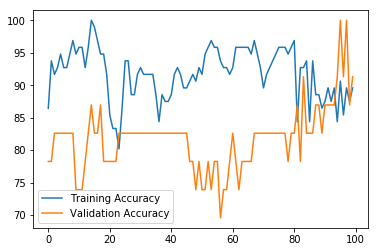

AD_SMI average accuracy is:  92.97304347826086
AD_SMI average standard deviation is:  4.81472245087222


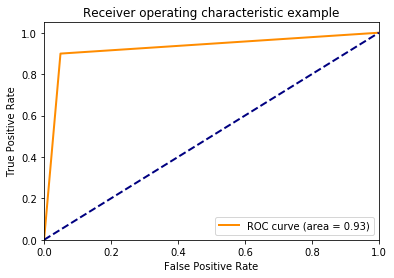

In [27]:
from sklearn.model_selection import RepeatedStratifiedKFold
from CNN_codes.CNN_with_addvariables import cnnm_training
from sklearn.metrics import roc_curve, auc

rskf=RepeatedStratifiedKFold(n_splits=5,n_repeats=5)
store_acc=[]
prediction=[]
truelabel=[]
for train_index,test_index in rskf.split(X_adsmi,y_adsmi):
    print("TRAIN:",train_index.shape,"TEST:",test_index.shape)
    # should augment data post split, think of incorporating the data augmention here
    X_train,X_test=X_adsmi[train_index],X_adsmi[test_index]
    y_train,y_test=y_adsmi[train_index],y_adsmi[test_index]
    X_trainvar,X_valvar=Xvar_adsmi[train_index],Xvar_adsmi[test_index]
    print(X_trainvar.shape)
    print(X_valvar.shape)
    
    mask_train = np.random.choice(len(X_train),len(X_train), replace=False)
    X_train=X_train[mask_train,:,:,:]
    y_train=y_train[mask_train,]
    X_trainvar=X_trainvar[mask_train,:]
    
    tf.reset_default_graph()
    record_acc,recordtrainacc,recordvalacc,roc_pred,roc_truelabel=cnnm_training(X_train,y_train,X_trainvar,X_test,y_test,X_valvar,fc_units=[3000,1000,2], 
                 conv_featmap=[6,10,16],l2_norm=0.01,seed=235,
                 learning_rate=1e-3,epoch=100,batch_size=10,imglen=164,addedvar_num=100)
    #record_acc,recordtrainacc,recordvalacc=cnn_training(X_train,y_train,X_test,y_test,fc_units=[500,200,2], 
    #             conv_featmap=[6,10,20],l2_norm=0.01,seed=235,
    #             learning_rate=1e-3,epoch=20,batch_size=10,imglen=164)
    store_acc.append(record_acc)
    prediction.extend(roc_pred)
    truelabel.extend(roc_truelabel)
    plt.plot(recordtrainacc,label='Training Accuracy')
    plt.plot(recordvalacc,label="Validation Accuracy")
    plt.legend()
    plt.show()

mean_acc=np.mean(np.array(store_acc))
mean_std=np.std(store_acc)

print('AD_SMI average accuracy is: ',mean_acc)
print('AD_SMI average standard deviation is: ',mean_std)
    
fpr,tpr,_=roc_curve(prediction,truelabel)
roc_auc=auc(fpr,tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.savefig('/Users/choyale/Desktop/Deep Learning Project/Figures/ADNI_ADSMI_ROC_curve_CNNM.jpg')
plt.show()

## Runn CNN with 5fold CV for MCI_SMI

TRAIN: [  0   1   2   3   4   5   6   7   8  10  11  13  14  15  16  17  18  19
  20  23  24  25  27  28  29  31  33  35  36  37  39  40  41  42  43  44
  45  46  47  49  51  52  53  54  55  57  58  59  60  61  62  64  66  67
  68  69  71  72  73  74  75  76  77  78  79  81  82  83  84  85  86  87
  88  89  90  91  94  95  96  97  98 100 101 102 103 105 107 110 111 112
 113 114 115 116 117 118 119 120 123 125 126 127 128 130] TEST: [  9  12  21  22  26  30  32  34  38  48  50  56  63  65  70  80  92  93
  99 104 106 108 109 121 122 124 129]
Number of training points:  (104,)
Number of testing points:  (27,)
Building Network Parameters: 
fc_units=[3000, 1000, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 10
epoch 1 
Best validation accuracy! iteration:10 accuracy: 51.851851851851855%
epoch 2 
Best validation accuracy! iteration:20 accuracy: 59.25925925925926%
epoch 3 
Best validation accuracy! iteration:30 accuracy: 62.96296296296296%
epoch 4 
epoch 5 
epo

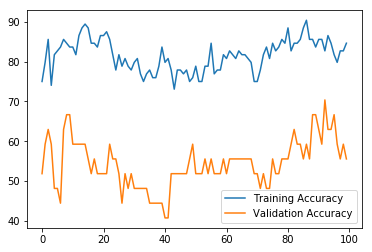

TRAIN: [  1   2   3   4   5   7   8   9  11  12  13  15  17  18  19  21  22  24
  25  26  27  28  29  30  31  32  34  35  36  37  38  39  41  42  43  44
  45  48  49  50  51  52  53  54  55  56  57  58  59  60  63  64  65  66
  67  68  70  71  72  73  74  76  77  78  79  80  81  82  83  86  87  90
  92  93  94  95  96  97  98  99 101 102 103 104 105 106 107 108 109 110
 111 113 114 116 118 120 121 122 123 124 126 127 128 129 130] TEST: [  0   6  10  14  16  20  23  33  40  46  47  61  62  69  75  84  85  88
  89  91 100 112 115 117 119 125]
Number of training points:  (105,)
Number of testing points:  (26,)
Building Network Parameters: 
fc_units=[3000, 1000, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 10
epoch 1 
Best validation accuracy! iteration:10 accuracy: 53.84615384615385%
epoch 2 
epoch 3 
epoch 4 
epoch 5 
Best validation accuracy! iteration:50 accuracy: 61.53846153846154%
epoch 6 
Best validation accuracy! iteration:60 accuracy: 65.38461538461

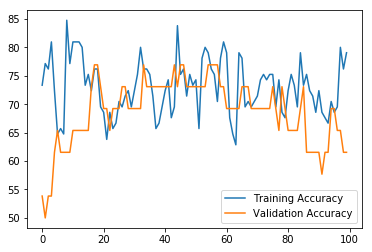

TRAIN: [  0   2   4   5   6   8   9  10  11  12  14  15  16  17  19  20  21  22
  23  26  27  29  30  31  32  33  34  36  38  39  40  41  42  43  45  46
  47  48  49  50  51  53  55  56  57  58  59  60  61  62  63  65  66  67
  68  69  70  72  74  75  78  80  81  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  99 100 103 104 105 106 107 108 109 110 112 113 114
 115 117 118 119 120 121 122 123 124 125 126 127 128 129 130] TEST: [  1   3   7  13  18  24  25  28  35  37  44  52  54  64  71  73  76  77
  79  82  97  98 101 102 111 116]
Number of training points:  (105,)
Number of testing points:  (26,)
Building Network Parameters: 
fc_units=[3000, 1000, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 10
epoch 1 
Best validation accuracy! iteration:10 accuracy: 69.23076923076923%
epoch 2 
epoch 3 
epoch 4 
epoch 5 
epoch 6 
epoch 7 
Best validation accuracy! iteration:70 accuracy: 73.07692307692308%
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
Best v

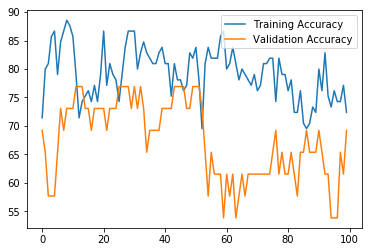

TRAIN: [  0   1   2   3   5   6   7   8   9  10  12  13  14  16  17  18  20  21
  22  23  24  25  26  27  28  30  32  33  34  35  37  38  39  40  41  42
  43  44  45  46  47  48  49  50  51  52  54  56  60  61  62  63  64  65
  66  69  70  71  73  74  75  76  77  79  80  81  82  84  85  87  88  89
  90  91  92  93  95  96  97  98  99 100 101 102 104 105 106 108 109 110
 111 112 114 115 116 117 118 119 121 122 124 125 126 129 130] TEST: [  4  11  15  19  29  31  36  53  55  57  58  59  67  68  72  78  83  86
  94 103 107 113 120 123 127 128]
Number of training points:  (105,)
Number of testing points:  (26,)
Building Network Parameters: 
fc_units=[3000, 1000, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 10
epoch 1 
Best validation accuracy! iteration:10 accuracy: 65.38461538461539%
epoch 2 
epoch 3 
epoch 4 
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
Best validation accuracy! iteration:120 accuracy: 73.07692307692308%
epoch

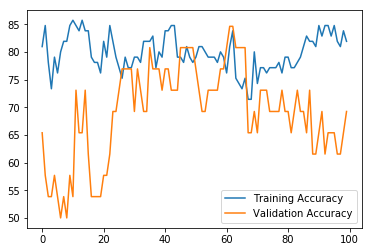

TRAIN: [  0   1   3   4   6   7   9  10  11  12  13  14  15  16  18  19  20  21
  22  23  24  25  26  28  29  30  31  32  33  34  35  36  37  38  40  44
  46  47  48  50  52  53  54  55  56  57  58  59  61  62  63  64  65  67
  68  69  70  71  72  73  75  76  77  78  79  80  82  83  84  85  86  88
  89  91  92  93  94  97  98  99 100 101 102 103 104 106 107 108 109 111
 112 113 115 116 117 119 120 121 122 123 124 125 127 128 129] TEST: [  2   5   8  17  27  39  41  42  43  45  49  51  60  66  74  81  87  90
  95  96 105 110 114 118 126 130]
Number of training points:  (105,)
Number of testing points:  (26,)
Building Network Parameters: 
fc_units=[3000, 1000, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 10
epoch 1 
Best validation accuracy! iteration:10 accuracy: 65.38461538461539%
epoch 2 
epoch 3 
epoch 4 
Best validation accuracy! iteration:40 accuracy: 73.07692307692308%
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 

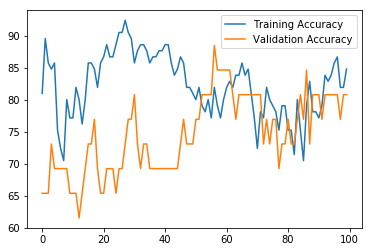

TRAIN: [  0   1   2   4   5   8   9  10  11  12  13  15  16  18  19  20  21  23
  24  25  26  27  28  30  31  32  33  34  36  37  38  39  40  41  42  43
  46  47  48  49  50  51  53  54  55  56  57  61  62  63  64  65  66  68
  69  70  71  72  74  75  76  77  78  79  80  81  82  83  84  85  86  87
  88  89  90  91  92  94  97  98  99 101 102 103 104 105 106 107 108 109
 110 112 117 118 119 120 122 123 124 125 127 128 129 130] TEST: [  3   6   7  14  17  22  29  35  44  45  52  58  59  60  67  73  93  95
  96 100 111 113 114 115 116 121 126]
Number of training points:  (104,)
Number of testing points:  (27,)
Building Network Parameters: 
fc_units=[3000, 1000, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 10
epoch 1 
Best validation accuracy! iteration:10 accuracy: 77.77777777777777%
epoch 2 
Best validation accuracy! iteration:20 accuracy: 81.48148148148148%
epoch 3 
epoch 4 
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 

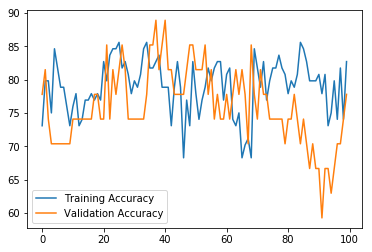

TRAIN: [  0   1   3   4   6   7   8   9  10  11  13  14  15  16  17  20  21  22
  25  27  29  30  31  33  34  35  36  38  39  40  42  43  44  45  47  48
  49  50  51  52  53  54  56  57  58  59  60  61  62  63  64  65  66  67
  68  69  70  71  73  74  75  76  77  78  79  81  83  84  87  88  91  92
  93  94  95  96  97  98 100 101 102 103 104 105 108 109 110 111 112 113
 114 115 116 117 119 120 121 122 123 124 125 126 127 128 129] TEST: [  2   5  12  18  19  23  24  26  28  32  37  41  46  55  72  80  82  85
  86  89  90  99 106 107 118 130]
Number of training points:  (105,)
Number of testing points:  (26,)
Building Network Parameters: 
fc_units=[3000, 1000, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 10
epoch 1 
Best validation accuracy! iteration:10 accuracy: 50.0%
epoch 2 
Best validation accuracy! iteration:20 accuracy: 57.69230769230769%
epoch 3 
epoch 4 
epoch 5 
Best validation accuracy! iteration:50 accuracy: 65.38461538461539%
epoch 6 
epoch 7 

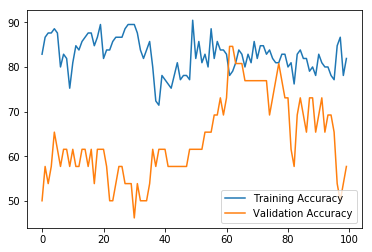

TRAIN: [  0   1   2   3   4   5   6   7   9  10  11  12  13  14  15  16  17  18
  19  22  23  24  25  26  27  28  29  31  32  34  35  36  37  39  41  42
  43  44  45  46  47  48  49  50  51  52  55  56  57  58  59  60  62  63
  67  68  70  71  72  73  74  79  80  82  85  86  87  88  89  90  91  92
  93  95  96  97  98  99 100 101 102 103 105 106 107 108 109 110 111 113
 114 115 116 117 118 119 120 121 122 124 125 126 128 129 130] TEST: [  8  20  21  30  33  38  40  53  54  61  64  65  66  69  75  76  77  78
  81  83  84  94 104 112 123 127]
Number of training points:  (105,)
Number of testing points:  (26,)
Building Network Parameters: 
fc_units=[3000, 1000, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 10
epoch 1 
Best validation accuracy! iteration:10 accuracy: 50.0%
epoch 2 
epoch 3 
epoch 4 
Best validation accuracy! iteration:40 accuracy: 53.84615384615385%
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
Best vali

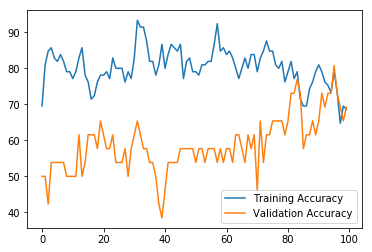

TRAIN: [  1   2   3   5   6   7   8  10  12  14  17  18  19  20  21  22  23  24
  25  26  28  29  30  31  32  33  35  36  37  38  40  41  42  44  45  46
  47  48  49  50  52  53  54  55  56  58  59  60  61  62  63  64  65  66
  67  68  69  71  72  73  74  75  76  77  78  80  81  82  83  84  85  86
  89  90  93  94  95  96  98  99 100 102 104 105 106 107 108 109 110 111
 112 113 114 115 116 117 118 120 121 123 124 126 127 128 130] TEST: [  0   4   9  11  13  15  16  27  34  39  43  51  57  70  79  87  88  91
  92  97 101 103 119 122 125 129]
Number of training points:  (105,)
Number of testing points:  (26,)
Building Network Parameters: 
fc_units=[3000, 1000, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 10
epoch 1 
Best validation accuracy! iteration:10 accuracy: 42.30769230769231%
epoch 2 
Best validation accuracy! iteration:20 accuracy: 50.0%
epoch 3 
Best validation accuracy! iteration:30 accuracy: 53.84615384615385%
epoch 4 
epoch 5 
epoch 6 
epoch 7 

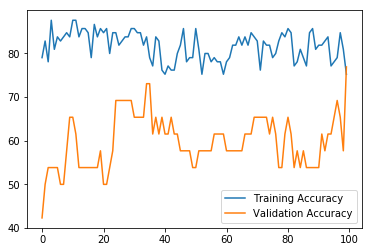

TRAIN: [  0   2   3   4   5   6   7   8   9  11  12  13  14  15  16  17  18  19
  20  21  22  23  24  26  27  28  29  30  32  33  34  35  37  38  39  40
  41  43  44  45  46  51  52  53  54  55  57  58  59  60  61  64  65  66
  67  69  70  72  73  75  76  77  78  79  80  81  82  83  84  85  86  87
  88  89  90  91  92  93  94  95  96  97  99 100 101 103 104 106 107 111
 112 113 114 115 116 118 119 121 122 123 125 126 127 129 130] TEST: [  1  10  25  31  36  42  47  48  49  50  56  62  63  68  71  74  98 102
 105 108 109 110 117 120 124 128]
Number of training points:  (105,)
Number of testing points:  (26,)
Building Network Parameters: 
fc_units=[3000, 1000, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 10
epoch 1 
Best validation accuracy! iteration:10 accuracy: 50.0%
epoch 2 
epoch 3 
epoch 4 
epoch 5 
Best validation accuracy! iteration:50 accuracy: 65.38461538461539%
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
Best validation accuracy! iteration:100

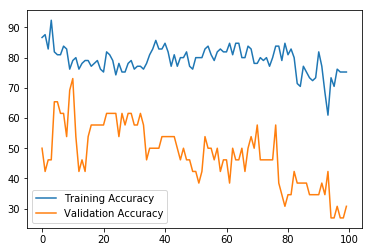

TRAIN: [  0   3   4   5   6   7   9  11  12  13  14  16  17  18  19  21  22  24
  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  41  42  43
  45  47  48  49  50  51  52  53  55  56  58  59  60  61  63  65  66  67
  69  70  71  72  73  74  75  76  78  79  80  81  82  83  84  85  86  87
  88  89  90  93  94  97  98  99 101 103 106 107 108 109 110 111 112 113
 115 116 117 118 119 121 122 124 125 126 127 128 129 130] TEST: [  1   2   8  10  15  20  23  40  44  46  54  57  62  64  68  77  91  92
  95  96 100 102 104 105 114 120 123]
Number of training points:  (104,)
Number of testing points:  (27,)
Building Network Parameters: 
fc_units=[3000, 1000, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 10
epoch 1 
Best validation accuracy! iteration:10 accuracy: 37.03703703703704%
epoch 2 
Best validation accuracy! iteration:20 accuracy: 51.851851851851855%
epoch 3 
epoch 4 
Best validation accuracy! iteration:40 accuracy: 55.55555555555556%
epoch 5 
epo

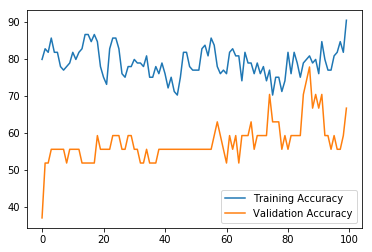

TRAIN: [  1   2   3   4   5   6   7   8   9  10  12  13  14  15  16  17  20  21
  22  23  24  25  27  28  29  30  31  32  33  35  36  37  38  40  41  44
  45  46  47  48  49  50  51  52  54  55  56  57  58  59  61  62  63  64
  66  67  68  71  72  74  75  77  78  79  80  81  84  86  87  88  89  90
  91  92  93  94  95  96  98  99 100 101 102 103 104 105 106 107 108 110
 111 112 113 114 115 116 119 120 123 124 126 127 128 129 130] TEST: [  0  11  18  19  26  34  39  42  43  53  60  65  69  70  73  76  82  83
  85  97 109 117 118 121 122 125]
Number of training points:  (105,)
Number of testing points:  (26,)
Building Network Parameters: 
fc_units=[3000, 1000, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 10
epoch 1 
Best validation accuracy! iteration:10 accuracy: 50.0%
epoch 2 
epoch 3 
epoch 4 
epoch 5 
Best validation accuracy! iteration:50 accuracy: 53.84615384615385%
epoch 6 
epoch 7 
epoch 8 
Best validation accuracy! iteration:80 accuracy: 61.538461

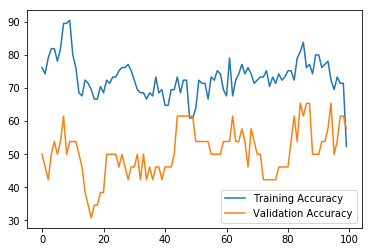

TRAIN: [  0   1   2   3   4   6   7   8   9  10  11  12  14  15  16  17  18  19
  20  21  22  23  24  25  26  27  29  30  31  33  34  37  38  39  40  42
  43  44  45  46  47  50  51  53  54  57  58  60  61  62  63  64  65  67
  68  69  70  71  73  74  75  76  77  78  79  82  83  84  85  87  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 107 109 110
 111 112 114 115 117 118 119 120 121 122 123 124 125 127 129] TEST: [  5  13  28  32  35  36  41  48  49  52  55  56  59  66  72  80  81  86
  88 106 108 113 116 126 128 130]
Number of training points:  (105,)
Number of testing points:  (26,)
Building Network Parameters: 
fc_units=[3000, 1000, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 10
epoch 1 
Best validation accuracy! iteration:10 accuracy: 61.53846153846154%
epoch 2 
epoch 3 
epoch 4 
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
Best validation accuracy! iteration:120 accuracy: 65.38461538461539%
epoch

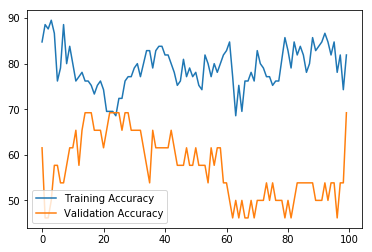

TRAIN: [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  20  23  24  26  27  28  29  32  33  34  35  36  39  40  41  42  43
  44  45  46  48  49  52  53  54  55  56  57  58  59  60  62  64  65  66
  68  69  70  71  72  73  76  77  78  80  81  82  83  84  85  86  87  88
  90  91  92  95  96  97  99 100 102 103 104 105 106 107 108 109 110 111
 113 114 116 117 118 120 121 122 123 124 125 126 127 128 130] TEST: [  7  21  22  25  30  31  37  38  47  50  51  61  63  67  74  75  79  89
  93  94  98 101 112 115 119 129]
Number of training points:  (105,)
Number of testing points:  (26,)
Building Network Parameters: 
fc_units=[3000, 1000, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 10
epoch 1 
Best validation accuracy! iteration:10 accuracy: 46.15384615384615%
epoch 2 
Best validation accuracy! iteration:20 accuracy: 61.53846153846154%
epoch 3 
Best validation accuracy! iteration:30 accuracy: 65.38461538461539%
epoch 4 
epoch 5 
epoc

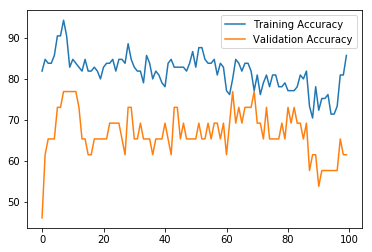

TRAIN: [  0   1   2   5   7   8  10  11  13  15  18  19  20  21  22  23  25  26
  28  30  31  32  34  35  36  37  38  39  40  41  42  43  44  46  47  48
  49  50  51  52  53  54  55  56  57  59  60  61  62  63  64  65  66  67
  68  69  70  72  73  74  75  76  77  79  80  81  82  83  85  86  88  89
  91  92  93  94  95  96  97  98 100 101 102 104 105 106 108 109 112 113
 114 115 116 117 118 119 120 121 122 123 125 126 128 129 130] TEST: [  3   4   6   9  12  14  16  17  24  27  29  33  45  58  71  78  84  87
  90  99 103 107 110 111 124 127]
Number of training points:  (105,)
Number of testing points:  (26,)
Building Network Parameters: 
fc_units=[3000, 1000, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 10
epoch 1 
Best validation accuracy! iteration:10 accuracy: 80.76923076923077%
epoch 2 
epoch 3 
epoch 4 
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
Best validation accuracy! iteration:90 accuracy: 84.61538461538461%
epoch 10 
epoch 11 
epoch 12 
epoch 

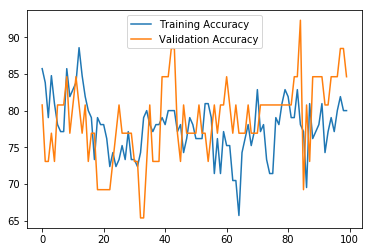

TRAIN: [  1   2   3   5   9  10  12  13  14  15  16  18  19  21  23  24  25  26
  27  28  29  30  31  33  34  35  36  37  38  39  40  43  44  45  46  47
  48  49  50  52  53  54  55  57  58  59  60  61  62  63  64  65  66  67
  68  69  71  73  74  76  78  80  81  83  84  86  87  88  89  90  91  93
  94  96  97  98  99 100 101 102 103 104 106 107 109 110 111 112 113 114
 115 116 118 119 120 121 122 124 125 126 127 128 129 130] TEST: [  0   4   6   7   8  11  17  20  22  32  41  42  51  56  70  72  75  77
  79  82  85  92  95 105 108 117 123]
Number of training points:  (104,)
Number of testing points:  (27,)
Building Network Parameters: 
fc_units=[3000, 1000, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 10
epoch 1 
Best validation accuracy! iteration:10 accuracy: 51.851851851851855%
epoch 2 
Best validation accuracy! iteration:20 accuracy: 70.37037037037037%
epoch 3 
epoch 4 
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch

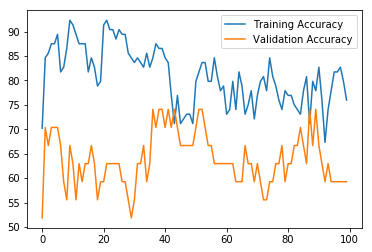

TRAIN: [  0   2   3   4   5   6   7   8   9  10  11  12  13  15  17  18  20  22
  24  25  26  27  28  29  31  32  33  34  35  36  37  38  39  40  41  42
  44  45  47  49  50  51  55  56  57  59  60  61  62  63  64  65  66  67
  68  69  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86
  88  89  90  92  93  94  95  97  98  99 100 101 102 103 104 105 106 108
 109 111 112 114 115 117 118 120 123 124 125 126 127 129 130] TEST: [  1  14  16  19  21  23  30  43  46  48  52  53  54  58  78  87  91  96
 107 110 113 116 119 121 122 128]
Number of training points:  (105,)
Number of testing points:  (26,)
Building Network Parameters: 
fc_units=[3000, 1000, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 10
epoch 1 
Best validation accuracy! iteration:10 accuracy: 57.69230769230769%
epoch 2 
Best validation accuracy! iteration:20 accuracy: 65.38461538461539%
epoch 3 
epoch 4 
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 

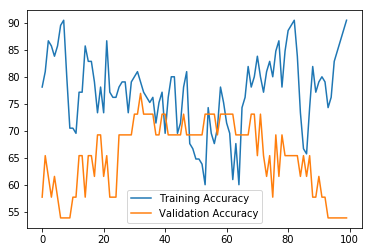

TRAIN: [  0   1   2   4   5   6   7   8   9  10  11  12  14  16  17  19  20  21
  22  23  24  26  27  28  29  30  31  32  33  34  35  37  38  39  40  41
  42  43  44  46  47  48  51  52  53  54  55  56  57  58  59  63  64  66
  68  69  70  71  72  73  74  75  77  78  79  80  82  83  84  85  87  88
  90  91  92  94  95  96  97  98 100 101 105 106 107 108 110 111 112 113
 114 116 117 119 120 121 122 123 124 125 126 127 128 129 130] TEST: [  3  13  15  18  25  36  45  49  50  60  61  62  65  67  76  81  86  89
  93  99 102 103 104 109 115 118]
Number of training points:  (105,)
Number of testing points:  (26,)
Building Network Parameters: 
fc_units=[3000, 1000, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 10
epoch 1 
Best validation accuracy! iteration:10 accuracy: 53.84615384615385%
epoch 2 
Best validation accuracy! iteration:20 accuracy: 61.53846153846154%
epoch 3 
epoch 4 
epoch 5 
Best validation accuracy! iteration:50 accuracy: 65.38461538461539%
epoc

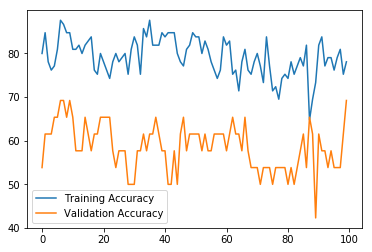

TRAIN: [  0   1   3   4   5   6   7   8  10  11  13  14  15  16  17  18  19  20
  21  22  23  24  25  29  30  31  32  34  35  36  41  42  43  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  60  61  62  64  65  66  67
  68  69  70  72  73  75  76  77  78  79  81  82  83  85  86  87  89  91
  92  93  94  95  96  97  99 101 102 103 104 105 107 108 109 110 111 113
 114 115 116 117 118 119 121 122 123 124 126 127 128 129 130] TEST: [  2   9  12  26  27  28  33  37  38  39  40  44  59  63  71  74  80  84
  88  90  98 100 106 112 120 125]
Number of training points:  (105,)
Number of testing points:  (26,)
Building Network Parameters: 
fc_units=[3000, 1000, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 10
epoch 1 
Best validation accuracy! iteration:10 accuracy: 50.0%
epoch 2 
Best validation accuracy! iteration:20 accuracy: 65.38461538461539%
epoch 3 
epoch 4 
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 

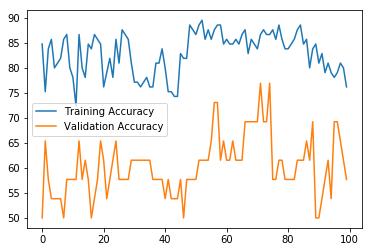

TRAIN: [  0   1   2   3   4   6   7   8   9  11  12  13  14  15  16  17  18  19
  20  21  22  23  25  26  27  28  30  32  33  36  37  38  39  40  41  42
  43  44  45  46  48  49  50  51  52  53  54  56  58  59  60  61  62  63
  65  67  70  71  72  74  75  76  77  78  79  80  81  82  84  85  86  87
  88  89  90  91  92  93  95  96  98  99 100 102 103 104 105 106 107 108
 109 110 112 113 115 116 117 118 119 120 121 122 123 125 128] TEST: [  5  10  24  29  31  34  35  47  55  57  64  66  68  69  73  83  94  97
 101 111 114 124 126 127 129 130]
Number of training points:  (105,)
Number of testing points:  (26,)
Building Network Parameters: 
fc_units=[3000, 1000, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 10
epoch 1 
Best validation accuracy! iteration:10 accuracy: 69.23076923076923%
epoch 2 
epoch 3 
epoch 4 
Best validation accuracy! iteration:40 accuracy: 73.07692307692308%
epoch 5 
Best validation accuracy! iteration:50 accuracy: 84.61538461538461%
epoc

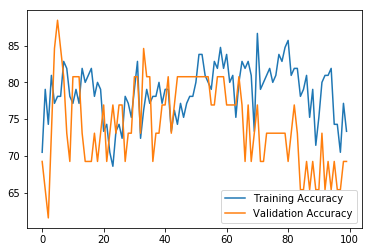

TRAIN: [  0   4   6   7   8   9  10  11  12  13  15  16  18  21  22  23  24  25
  26  27  28  29  31  32  33  34  35  36  38  39  40  41  42  44  45  46
  47  48  51  52  53  54  55  56  57  58  59  60  61  62  63  64  66  67
  68  70  71  72  73  74  77  78  79  81  82  84  86  87  88  89  91  92
  93  94  96  97  99 100 101 102 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 117 118 120 122 123 124 127 128 129 130] TEST: [  1   2   3   5  14  17  19  20  30  37  43  49  50  65  69  75  76  80
  83  85  90  95  98 119 121 125 126]
Number of training points:  (104,)
Number of testing points:  (27,)
Building Network Parameters: 
fc_units=[3000, 1000, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 10
epoch 1 
Best validation accuracy! iteration:10 accuracy: 55.55555555555556%
epoch 2 
epoch 3 
epoch 4 
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
Best validation accuracy! iteration:140 accuracy: 59.2

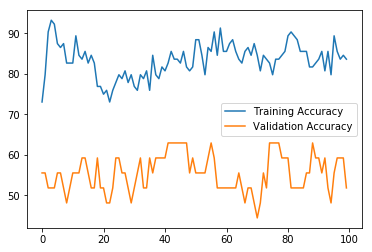

TRAIN: [  0   1   2   3   4   5   7   8  10  11  12  13  14  15  16  17  18  19
  20  21  22  23  24  25  26  27  28  29  30  34  35  36  37  38  39  40
  41  42  43  44  45  47  48  49  50  52  53  54  56  58  59  62  65  67
  68  69  70  71  72  73  74  75  76  77  78  80  81  83  85  86  87  88
  89  90  91  93  94  95  96  97  98  99 100 104 105 108 109 110 111 112
 114 115 116 117 118 119 120 121 122 123 125 126 127 128 130] TEST: [  6   9  31  32  33  46  51  55  57  60  61  63  64  66  79  82  84  92
 101 102 103 106 107 113 124 129]
Number of training points:  (105,)
Number of testing points:  (26,)
Building Network Parameters: 
fc_units=[3000, 1000, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 10
epoch 1 
Best validation accuracy! iteration:10 accuracy: 50.0%
epoch 2 
Best validation accuracy! iteration:20 accuracy: 57.69230769230769%
epoch 3 
Best validation accuracy! iteration:30 accuracy: 61.53846153846154%
epoch 4 
Best validation accuracy! 

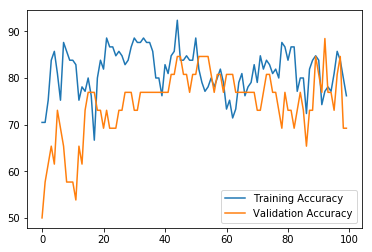

TRAIN: [  1   2   3   5   6   7   8   9  10  11  13  14  15  16  17  19  20  21
  23  24  26  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  48  49  50  51  53  55  56  57  59  60  61  62  63  64  65  66
  68  69  70  72  75  76  77  78  79  80  81  82  83  84  85  86  87  89
  90  91  92  94  95  98 100 101 102 103 104 105 106 107 108 109 110 113
 114 115 117 118 119 120 121 123 124 125 126 127 128 129 130] TEST: [  0   4  12  18  22  25  27  28  35  47  52  54  58  67  71  73  74  88
  93  96  97  99 111 112 116 122]
Number of training points:  (105,)
Number of testing points:  (26,)
Building Network Parameters: 
fc_units=[3000, 1000, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 10
epoch 1 
Best validation accuracy! iteration:10 accuracy: 61.53846153846154%
epoch 2 
epoch 3 
epoch 4 
epoch 5 
Best validation accuracy! iteration:50 accuracy: 73.07692307692308%
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 

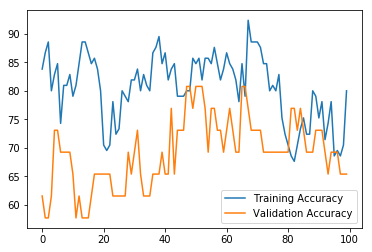

TRAIN: [  0   1   2   3   4   5   6   7   9  10  12  13  14  17  18  19  20  21
  22  24  25  26  27  28  30  31  32  33  34  35  36  37  39  41  43  44
  46  47  48  49  50  51  52  53  54  55  57  58  60  61  63  64  65  66
  67  68  69  71  73  74  75  76  77  78  79  80  81  82  83  84  85  86
  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 105 106
 107 111 112 113 115 116 119 121 122 124 125 126 128 129 130] TEST: [  8  11  15  16  23  29  38  40  42  45  56  59  62  70  72  87 104 108
 109 110 114 117 118 120 123 127]
Number of training points:  (105,)
Number of testing points:  (26,)
Building Network Parameters: 
fc_units=[3000, 1000, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 10
epoch 1 
Best validation accuracy! iteration:10 accuracy: 69.23076923076923%
epoch 2 
epoch 3 
epoch 4 
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
Best validation accuracy! iteration:130 accuracy: 73.07692307692

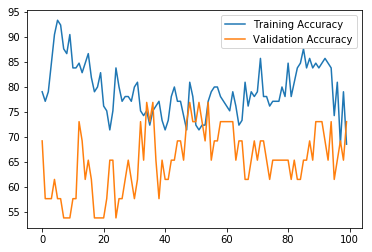

TRAIN: [  0   1   2   3   4   5   6   8   9  11  12  14  15  16  17  18  19  20
  22  23  25  27  28  29  30  31  32  33  35  37  38  40  42  43  45  46
  47  49  50  51  52  54  55  56  57  58  59  60  61  62  63  64  65  66
  67  69  70  71  72  73  74  75  76  79  80  82  83  84  85  87  88  90
  92  93  95  96  97  98  99 101 102 103 104 106 107 108 109 110 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 129] TEST: [  7  10  13  21  24  26  34  36  39  41  44  48  53  68  77  78  81  86
  89  91  94 100 105 115 128 130]
Number of training points:  (105,)
Number of testing points:  (26,)
Building Network Parameters: 
fc_units=[3000, 1000, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 10
epoch 1 
Best validation accuracy! iteration:10 accuracy: 57.69230769230769%
epoch 2 
epoch 3 
Best validation accuracy! iteration:30 accuracy: 65.38461538461539%
epoch 4 
epoch 5 
Best validation accuracy! iteration:50 accuracy: 73.07692307692308%
epoc

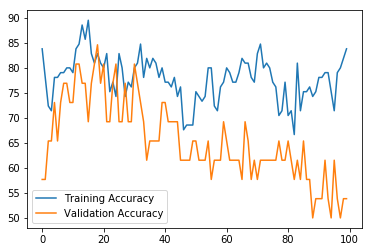

MCI_SMI average accuracy is:  78.5014245014245
MCI_SMI average standard deviation is:  7.581658553114837


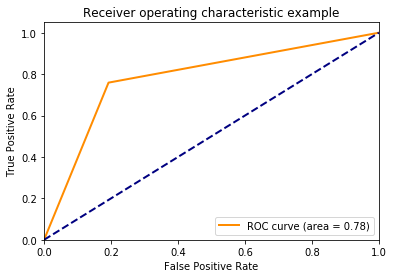

In [28]:
from sklearn.model_selection import RepeatedStratifiedKFold
from CNN_codes.CNN_with_addvariables import cnnm_training
from sklearn.metrics import roc_curve, auc

rskf=RepeatedStratifiedKFold(n_splits=5,n_repeats=5)
store_acc=[]
prediction=[]
truelabel=[]
for train_index,test_index in rskf.split(X_mcismi,y_mcismi):
    print("TRAIN:",train_index,"TEST:",test_index)
    print("Number of training points: ",train_index.shape)
    print('Number of testing points: ',test_index.shape)
    X_train,X_test=X_mcismi[train_index],X_mcismi[test_index]
    y_train,y_test=y_mcismi[train_index],y_mcismi[test_index]
    X_trainvar,X_valvar=Xvar_mcismi[train_index],Xvar_mcismi[test_index]
    tf.reset_default_graph()
    
    mask_train = np.random.choice(len(X_train),len(X_train), replace=False)
    X_train=X_train[mask_train,:,:,:]
    y_train=y_train[mask_train,]
    X_trainvar=X_trainvar[mask_train,:]
    
    record_acc,recordtrainacc,recordvalacc,roc_pred,roc_truelabel=cnnm_training(X_train,y_train,X_trainvar,X_test,y_test,X_valvar,fc_units=[3000,1000,2], 
                 conv_featmap=[6,10,16],l2_norm=0.01,seed=235,
                 learning_rate=1e-3,epoch=100,batch_size=10,imglen=164,addedvar_num=100)
    
    store_acc.append(record_acc)
    prediction.extend(roc_pred)
    truelabel.extend(roc_truelabel)
    plt.plot(recordtrainacc,label='Training Accuracy')
    plt.plot(recordvalacc,label="Validation Accuracy")
    plt.legend()
    plt.show()

mean_acc=np.mean(np.array(store_acc))
mean_std=np.std(store_acc)
print('MCI_SMI average accuracy is: ',mean_acc)
print('MCI_SMI average standard deviation is: ',mean_std)

fpr,tpr,_=roc_curve(prediction,truelabel)
roc_auc=auc(fpr,tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.savefig('/Users/choyale/Desktop/Deep Learning Project/Figures/ADNI_ADSMI_ROC_curve_CNNM.jpg')
plt.show()

## Run CNN with 5fold CV for AD_MCI

TRAIN: [  0   1   3   4   5   6   8   9  10  12  14  15  16  17  18  19  20  21
  22  23  24  25  26  28  30  31  32  33  34  35  37  38  39  41  43  44
  45  46  47  48  49  50  52  53  54  57  58  59  60  61  62  63  64  65
  66  69  70  71  72  74  76  77  78  79  80  81  82  83  84  85  86  87
  90  91  92  93  96  97  98  99 101 102 103 104 105 107] TEST: [  2   7  11  13  27  29  36  40  42  51  55  56  67  68  73  75  88  89
  94  95 100 106]
Number of training points:  (86,)
Number of testing points:  (22,)
Building Network Parameters: 
fc_units=[3000, 1000, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 10
epoch 1 
Best validation accuracy! iteration:10 accuracy: 59.09090909090909%
epoch 2 
Best validation accuracy! iteration:20 accuracy: 72.72727272727272%
epoch 3 
epoch 4 
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch 17 
epoch 18 
Best validation accuracy! iteration:180 

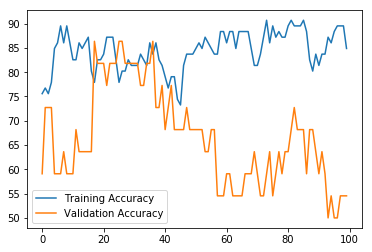

TRAIN: [  0   1   2   4   5   7   8   9  10  11  12  13  15  16  17  18  22  23
  24  26  27  28  29  30  33  34  35  36  37  38  40  41  42  43  44  45
  46  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  67  68
  69  71  73  74  75  76  77  78  80  81  82  83  84  85  86  88  89  90
  91  92  93  94  95  97  98  99 100 101 103 104 105 106] TEST: [  3   6  14  19  20  21  25  31  32  39  47  48  61  65  66  70  72  79
  87  96 102 107]
Number of training points:  (86,)
Number of testing points:  (22,)
Building Network Parameters: 
fc_units=[3000, 1000, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 10
epoch 1 
Best validation accuracy! iteration:10 accuracy: 77.27272727272728%
epoch 2 
epoch 3 
epoch 4 
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
epoch 21 
epoch 22 
epoch 23 
epoch 24 
epoch 25 
epoch 26 
epoch 27 
epoch 28 
epoch 29

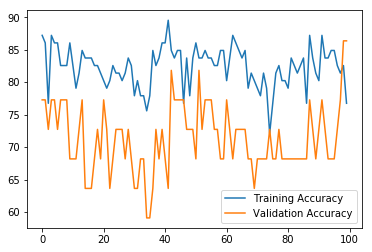

TRAIN: [  0   2   3   4   5   6   7  11  12  13  14  15  19  20  21  24  25  26
  27  28  29  30  31  32  34  35  36  37  39  40  41  42  43  44  45  46
  47  48  49  50  51  52  53  54  55  56  57  59  60  61  63  64  65  66
  67  68  69  70  71  72  73  75  77  78  79  81  83  84  87  88  89  90
  92  93  94  95  96  97  98  99 100 102 103 105 106 107] TEST: [  1   8   9  10  16  17  18  22  23  33  38  58  62  74  76  80  82  85
  86  91 101 104]
Number of training points:  (86,)
Number of testing points:  (22,)
Building Network Parameters: 
fc_units=[3000, 1000, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 10
epoch 1 
Best validation accuracy! iteration:10 accuracy: 68.18181818181819%
epoch 2 
Best validation accuracy! iteration:20 accuracy: 77.27272727272728%
epoch 3 
epoch 4 
epoch 5 
epoch 6 
epoch 7 
Best validation accuracy! iteration:70 accuracy: 81.81818181818181%
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
ep

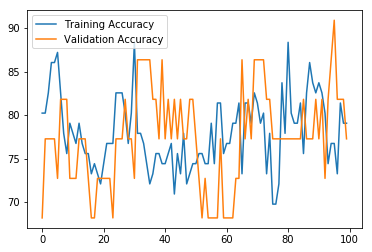

TRAIN: [  1   2   3   5   6   7   8   9  10  11  13  14  16  17  18  19  20  21
  22  23  24  25  27  28  29  30  31  32  33  34  36  37  38  39  40  41
  42  43  45  47  48  49  51  52  55  56  57  58  61  62  65  66  67  68
  70  72  73  74  75  76  79  80  81  82  84  85  86  87  88  89  91  92
  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107] TEST: [ 0  4 12 15 26 35 44 46 50 53 54 59 60 63 64 69 71 77 78 83 90]
Number of training points:  (87,)
Number of testing points:  (21,)
Building Network Parameters: 
fc_units=[3000, 1000, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 10
epoch 1 
Best validation accuracy! iteration:10 accuracy: 61.904761904761905%
epoch 2 
epoch 3 
epoch 4 
epoch 5 
epoch 6 
Best validation accuracy! iteration:60 accuracy: 66.66666666666666%
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
epoch 21 
epoch 22 
epoch 23 
epoch 24 
e

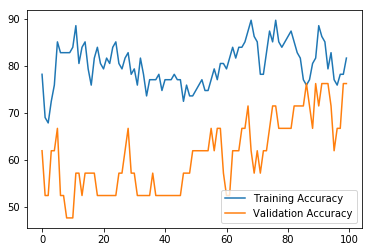

TRAIN: [  0   1   2   3   4   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  25  26  27  29  31  32  33  35  36  38  39  40  42
  44  46  47  48  50  51  53  54  55  56  58  59  60  61  62  63  64  65
  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  82  83  85
  86  87  88  89  90  91  94  95  96 100 101 102 104 106 107] TEST: [  5  24  28  30  34  37  41  43  45  49  52  57  81  84  92  93  97  98
  99 103 105]
Number of training points:  (87,)
Number of testing points:  (21,)
Building Network Parameters: 
fc_units=[3000, 1000, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 10
epoch 1 
Best validation accuracy! iteration:10 accuracy: 57.142857142857146%
epoch 2 
epoch 3 
epoch 4 
epoch 5 
epoch 6 
epoch 7 
epoch 8 
Best validation accuracy! iteration:80 accuracy: 61.904761904761905%
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
epoch 21 
epoch 22

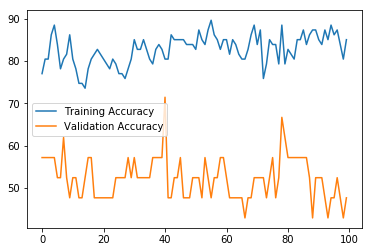

TRAIN: [  0   1   2   3   4   5   7   8   9  10  11  12  15  16  17  18  19  20
  21  22  24  25  27  29  30  31  32  33  35  38  39  41  42  43  44  45
  46  48  49  50  51  52  53  54  55  56  57  58  63  65  66  67  68  69
  70  71  72  73  75  77  78  79  80  81  82  84  85  86  87  89  90  91
  92  94  95  96  97  98  99 100 101 103 104 105 106 107] TEST: [  6  13  14  23  26  28  34  36  37  40  47  59  60  61  62  64  74  76
  83  88  93 102]
Number of training points:  (86,)
Number of testing points:  (22,)
Building Network Parameters: 
fc_units=[3000, 1000, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 10
epoch 1 
Best validation accuracy! iteration:10 accuracy: 63.63636363636363%
epoch 2 
Best validation accuracy! iteration:20 accuracy: 72.72727272727272%
epoch 3 
epoch 4 
epoch 5 
epoch 6 
epoch 7 
epoch 8 
Best validation accuracy! iteration:80 accuracy: 77.27272727272728%
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
ep

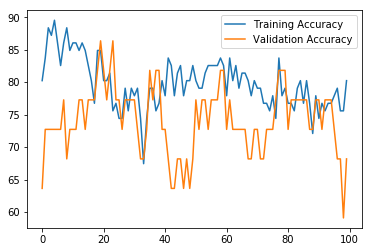

TRAIN: [  0   1   2   3   5   6   9  10  13  14  16  17  18  19  20  21  22  23
  24  25  26  27  28  29  30  32  33  34  35  36  37  38  39  40  41  42
  43  44  45  46  47  51  52  54  56  57  58  59  60  61  62  63  64  65
  66  67  68  69  70  74  75  76  77  78  79  81  82  83  84  85  87  88
  89  90  93  94  96  97  98  99 102 103 104 105 106 107] TEST: [  4   7   8  11  12  15  31  48  49  50  53  55  71  72  73  80  86  91
  92  95 100 101]
Number of training points:  (86,)
Number of testing points:  (22,)
Building Network Parameters: 
fc_units=[3000, 1000, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 10
epoch 1 
Best validation accuracy! iteration:10 accuracy: 59.09090909090909%
epoch 2 
epoch 3 
epoch 4 
Best validation accuracy! iteration:40 accuracy: 63.63636363636363%
epoch 5 
epoch 6 
Best validation accuracy! iteration:60 accuracy: 68.18181818181819%
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
ep

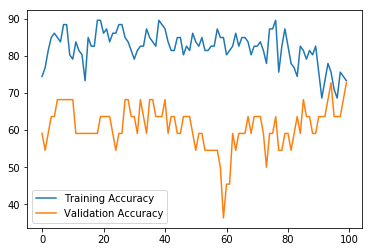

TRAIN: [  1   2   4   6   7   8   9  11  12  13  14  15  16  18  19  20  21  23
  24  25  26  27  28  29  30  31  33  34  36  37  38  39  40  41  42  44
  46  47  48  49  50  53  54  55  56  57  58  59  60  61  62  63  64  65
  66  67  68  70  71  72  73  74  76  77  80  82  83  84  85  86  87  88
  89  90  91  92  93  94  95  97  98  99 100 101 102 105] TEST: [  0   3   5  10  17  22  32  35  43  45  51  52  69  75  78  79  81  96
 103 104 106 107]
Number of training points:  (86,)
Number of testing points:  (22,)
Building Network Parameters: 
fc_units=[3000, 1000, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 10
epoch 1 
Best validation accuracy! iteration:10 accuracy: 72.72727272727272%
epoch 2 
Best validation accuracy! iteration:20 accuracy: 81.81818181818181%
epoch 3 
epoch 4 
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
epoch 21 
epoch 22 


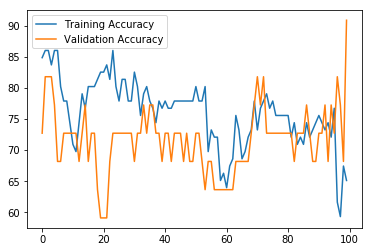

TRAIN: [  0   2   3   4   5   6   7   8   9  10  11  12  13  14  15  17  18  22
  23  24  25  26  27  28  30  31  32  34  35  36  37  38  39  40  43  45
  47  48  49  50  51  52  53  54  55  56  58  59  60  61  62  64  65  66
  68  69  71  72  73  74  75  76  77  78  79  80  81  82  83  86  88  89
  91  92  93  94  95  96  97  98 100 101 102 103 104 106 107] TEST: [  1  16  19  20  21  29  33  41  42  44  46  57  63  67  70  84  85  87
  90  99 105]
Number of training points:  (87,)
Number of testing points:  (21,)
Building Network Parameters: 
fc_units=[3000, 1000, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 10
epoch 1 
Best validation accuracy! iteration:10 accuracy: 61.904761904761905%
epoch 2 
epoch 3 
epoch 4 
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch 17 
Best validation accuracy! iteration:170 accuracy: 66.66666666666666%
epoch 18 
epoch 19 
epoch 20 
epoch 21 
epoch 22

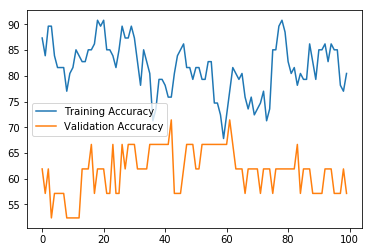

TRAIN: [  0   1   3   4   5   6   7   8  10  11  12  13  14  15  16  17  19  20
  21  22  23  26  28  29  31  32  33  34  35  36  37  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  55  57  59  60  61  62  63  64  67
  69  70  71  72  73  74  75  76  78  79  80  81  83  84  85  86  87  88
  90  91  92  93  95  96  99 100 101 102 103 104 105 106 107] TEST: [ 2  9 18 24 25 27 30 38 39 54 56 58 65 66 68 77 82 89 94 97 98]
Number of training points:  (87,)
Number of testing points:  (21,)
Building Network Parameters: 
fc_units=[3000, 1000, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 10
epoch 1 
Best validation accuracy! iteration:10 accuracy: 61.904761904761905%
epoch 2 
Best validation accuracy! iteration:20 accuracy: 66.66666666666666%
epoch 3 
Best validation accuracy! iteration:30 accuracy: 76.19047619047619%
epoch 4 
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
Best validation accuracy! iteration:90 accuracy: 80.95238095238095%
epoch 10 
epoch

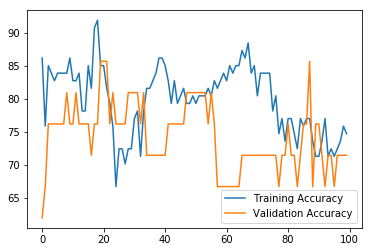

TRAIN: [  0   1   2   3   4   5   6   7   8   9  12  13  14  16  17  18  19  20
  21  22  23  24  25  26  27  28  30  34  35  36  37  39  41  42  43  44
  45  46  47  48  49  50  51  53  54  57  58  59  60  61  62  63  64  65
  66  67  68  69  70  71  72  73  77  79  80  81  82  83  84  85  86  89
  90  91  92  93  94  95  96  98  99 100 101 105 106 107] TEST: [ 10  11  15  29  31  32  33  38  40  52  55  56  74  75  76  78  87  88
  97 102 103 104]
Number of training points:  (86,)
Number of testing points:  (22,)
Building Network Parameters: 
fc_units=[3000, 1000, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 10
epoch 1 
Best validation accuracy! iteration:10 accuracy: 54.54545454545455%
epoch 2 
Best validation accuracy! iteration:20 accuracy: 59.09090909090909%
epoch 3 
epoch 4 
epoch 5 
Best validation accuracy! iteration:50 accuracy: 63.63636363636363%
epoch 6 
Best validation accuracy! iteration:60 accuracy: 68.18181818181819%
epoch 7 
epoch 8 
epo

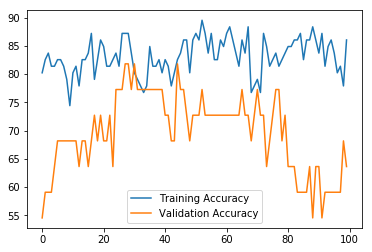

TRAIN: [  0   1   2   5   6   8   9  10  11  12  14  15  16  18  19  22  23  24
  25  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43
  44  45  46  47  49  50  51  52  53  55  56  59  60  61  62  64  66  67
  69  70  71  72  73  74  75  76  77  78  80  82  85  86  87  88  89  90
  91  93  94  95  96  97  98  99 102 103 104 105 106 107] TEST: [  3   4   7  13  17  20  21  26  48  54  57  58  63  65  68  79  81  83
  84  92 100 101]
Number of training points:  (86,)
Number of testing points:  (22,)
Building Network Parameters: 
fc_units=[3000, 1000, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 10
epoch 1 
Best validation accuracy! iteration:10 accuracy: 72.72727272727272%
epoch 2 
epoch 3 
epoch 4 
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
Best validation accuracy! iteration:90 accuracy: 77.27272727272728%
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
epoch 21 
epoch 22 


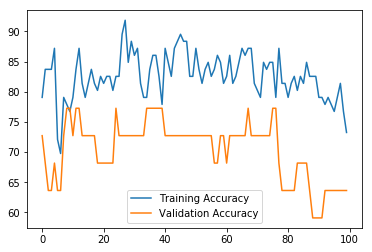

TRAIN: [  0   1   3   4   6   7   9  10  11  13  14  15  16  17  20  21  22  23
  24  25  26  28  29  30  31  32  33  34  35  37  38  39  40  41  42  44
  45  46  48  50  51  52  53  54  55  56  57  58  60  62  63  64  65  66
  67  68  70  71  74  75  76  77  78  79  80  81  82  83  84  87  88  89
  90  92  93  96  97  98  99 100 101 102 103 104 105 107] TEST: [  2   5   8  12  18  19  27  36  43  47  49  59  61  69  72  73  85  86
  91  94  95 106]
Number of training points:  (86,)
Number of testing points:  (22,)
Building Network Parameters: 
fc_units=[3000, 1000, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 10
epoch 1 
Best validation accuracy! iteration:10 accuracy: 50.0%
epoch 2 
Best validation accuracy! iteration:20 accuracy: 72.72727272727272%
epoch 3 
epoch 4 
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
epoch 21 
epoch 22 
epoch 23 
epo

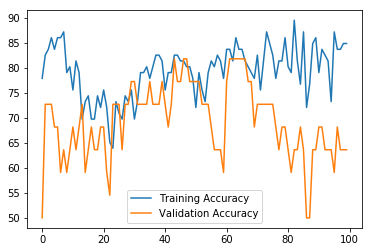

TRAIN: [  1   2   3   4   5   6   7   8   9  10  11  12  13  15  16  17  18  19
  20  21  24  25  26  27  29  31  32  33  34  36  38  39  40  42  43  44
  45  47  48  49  50  52  54  55  56  57  58  59  61  62  63  64  65  66
  68  69  70  72  73  74  75  76  77  78  79  81  82  83  84  85  86  87
  88  91  92  94  95  97  98  99 100 101 102 103 104 106 107] TEST: [  0  14  22  23  28  30  35  37  41  46  51  53  60  67  71  80  89  90
  93  96 105]
Number of training points:  (87,)
Number of testing points:  (21,)
Building Network Parameters: 
fc_units=[3000, 1000, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 10
epoch 1 
Best validation accuracy! iteration:10 accuracy: 61.904761904761905%
epoch 2 
epoch 3 
Best validation accuracy! iteration:30 accuracy: 66.66666666666666%
epoch 4 
epoch 5 
epoch 6 
epoch 7 
Best validation accuracy! iteration:70 accuracy: 76.19047619047619%
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
e

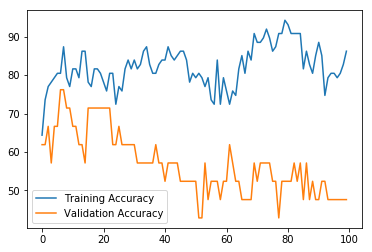

TRAIN: [  0   2   3   4   5   7   8  10  11  12  13  14  15  17  18  19  20  21
  22  23  26  27  28  29  30  31  32  33  35  36  37  38  40  41  43  46
  47  48  49  51  52  53  54  55  56  57  58  59  60  61  63  65  67  68
  69  71  72  73  74  75  76  78  79  80  81  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106] TEST: [  1   6   9  16  24  25  34  39  42  44  45  50  62  64  66  70  77  82
  98  99 107]
Number of training points:  (87,)
Number of testing points:  (21,)
Building Network Parameters: 
fc_units=[3000, 1000, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 10
epoch 1 
Best validation accuracy! iteration:10 accuracy: 71.42857142857143%
epoch 2 
epoch 3 
epoch 4 
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
Best validation accuracy! iteration:140 accuracy: 90.47619047619048%
epoch 15 
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
epoch 21 
epoch 22 

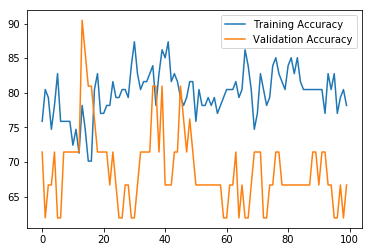

TRAIN: [  0   1   2   4   5   6   7   8   9  10  11  12  13  15  16  18  19  20
  21  23  24  27  28  29  32  33  34  36  37  38  39  40  41  42  43  45
  46  47  48  49  50  51  52  53  54  57  58  59  60  61  62  63  64  66
  67  69  70  71  73  74  76  77  78  79  80  81  82  84  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 103 105 106] TEST: [  3  14  17  22  25  26  30  31  35  44  55  56  65  68  72  75  83  85
 101 102 104 107]
Number of training points:  (86,)
Number of testing points:  (22,)
Building Network Parameters: 
fc_units=[3000, 1000, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 10
epoch 1 
Best validation accuracy! iteration:10 accuracy: 68.18181818181819%
epoch 2 
epoch 3 
epoch 4 
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
Best validation accuracy! iteration:110 accuracy: 72.72727272727272%
epoch 12 
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
epoch 21 
epoch 22 

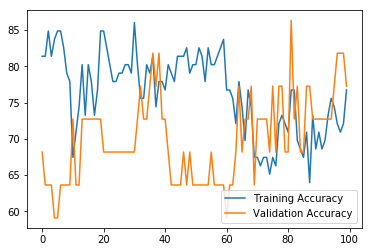

TRAIN: [  0   1   2   3   5   6   7   8  10  11  13  14  15  16  17  18  19  20
  22  23  24  25  26  27  28  29  30  31  32  34  35  36  38  39  40  42
  43  44  45  47  49  51  53  54  55  56  57  59  60  61  62  63  64  65
  66  67  68  69  71  72  73  75  76  77  81  82  83  85  86  87  88  89
  90  91  92  93  94  96  97 101 102 103 104 105 106 107] TEST: [  4   9  12  21  33  37  41  46  48  50  52  58  70  74  78  79  80  84
  95  98  99 100]
Number of training points:  (86,)
Number of testing points:  (22,)
Building Network Parameters: 
fc_units=[3000, 1000, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 10
epoch 1 
Best validation accuracy! iteration:10 accuracy: 50.0%
epoch 2 
Best validation accuracy! iteration:20 accuracy: 63.63636363636363%
epoch 3 
Best validation accuracy! iteration:30 accuracy: 77.27272727272728%
epoch 4 
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch

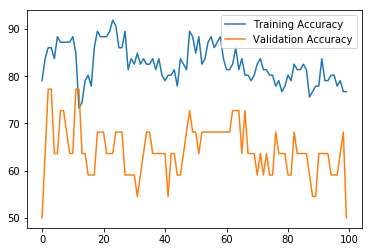

TRAIN: [  0   1   2   3   4   5   6   8   9  11  12  13  14  16  17  18  19  20
  21  22  23  24  25  26  28  30  31  33  34  35  36  37  41  44  45  46
  47  48  50  51  52  53  54  55  56  57  58  59  60  63  65  66  67  68
  70  71  72  73  74  75  76  77  78  79  80  83  84  85  86  88  89  90
  91  92  95  96  98  99 100 101 102 103 104 105 106 107] TEST: [ 7 10 15 27 29 32 38 39 40 42 43 49 61 62 64 69 81 82 87 93 94 97]
Number of training points:  (86,)
Number of testing points:  (22,)
Building Network Parameters: 
fc_units=[3000, 1000, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 10
epoch 1 
Best validation accuracy! iteration:10 accuracy: 50.0%
epoch 2 
Best validation accuracy! iteration:20 accuracy: 54.54545454545455%
epoch 3 
epoch 4 
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch 17 
Best validation accuracy! iteration:170 accuracy: 59.09090909090909%
epoch 18 
epoch 1

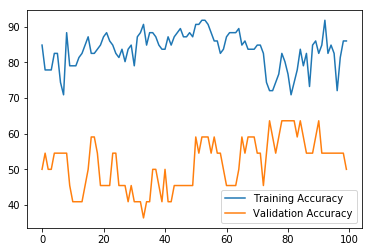

TRAIN: [  0   1   3   4   6   7   9  10  11  12  14  15  16  17  18  20  21  22
  23  25  26  27  29  30  31  32  33  35  37  38  39  40  41  42  43  44
  46  47  48  49  50  51  52  53  55  56  58  59  61  62  63  64  65  66
  68  69  70  71  72  73  74  75  78  79  80  81  82  83  84  85  87  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 106 107] TEST: [  2   5   8  13  19  24  28  34  36  45  54  57  60  67  76  77  86  88
  89  90 105]
Number of training points:  (87,)
Number of testing points:  (21,)
Building Network Parameters: 
fc_units=[3000, 1000, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 10
epoch 1 
Best validation accuracy! iteration:10 accuracy: 61.904761904761905%
epoch 2 
epoch 3 
epoch 4 
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
epoch 21 
epoch 22 
epoch 23 
epoch 24 
epoch 25 
epoch 26 
epoch 27 
epoch 28 
epoch 2

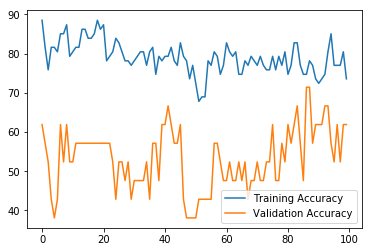

TRAIN: [  2   3   4   5   7   8   9  10  12  13  14  15  17  19  21  22  24  25
  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43
  44  45  46  48  49  50  52  54  55  56  57  58  60  61  62  64  65  67
  68  69  70  72  74  75  76  77  78  79  80  81  82  83  84  85  86  87
  88  89  90  93  94  95  97  98  99 100 101 102 104 105 107] TEST: [  0   1   6  11  16  18  20  23  47  51  53  59  63  66  71  73  91  92
  96 103 106]
Number of training points:  (87,)
Number of testing points:  (21,)
Building Network Parameters: 
fc_units=[3000, 1000, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 10
epoch 1 
Best validation accuracy! iteration:10 accuracy: 61.904761904761905%
epoch 2 
epoch 3 
Best validation accuracy! iteration:30 accuracy: 66.66666666666666%
epoch 4 
Best validation accuracy! iteration:40 accuracy: 71.42857142857143%
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
e

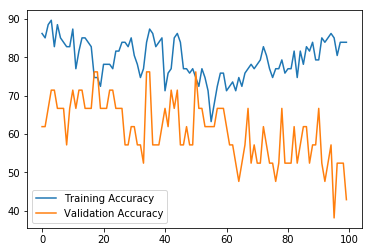

TRAIN: [  0   1   2   4   5   6   7   8  10  11  12  17  18  19  20  21  23  24
  25  26  27  28  29  30  31  32  34  35  36  38  39  40  41  43  44  45
  46  47  48  50  51  52  53  54  56  57  58  59  60  62  64  65  67  68
  69  70  73  74  75  76  77  78  79  80  81  82  84  85  86  87  88  90
  91  92  93  94  95  96  97  99 100 101 103 104 106 107] TEST: [  3   9  13  14  15  16  22  33  37  42  49  55  61  63  66  71  72  83
  89  98 102 105]
Number of training points:  (86,)
Number of testing points:  (22,)
Building Network Parameters: 
fc_units=[3000, 1000, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 10
epoch 1 
Best validation accuracy! iteration:10 accuracy: 50.0%
epoch 2 
epoch 3 
epoch 4 
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
epoch 21 
epoch 22 
epoch 23 
epoch 24 
epoch 25 
epoch 26 
epoch 27 
epoch 28 
epoch 29 
epoch 30 
e

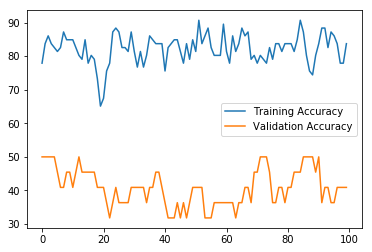

TRAIN: [  0   1   2   3   6   9  10  12  13  14  15  16  17  18  19  20  21  22
  23  24  25  26  27  28  29  30  33  34  35  37  39  42  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  61  63  64  65  66
  67  68  69  70  71  72  74  75  76  77  78  79  80  81  82  83  84  86
  87  89  90  92  93  94  95  96  98 100 101 102 105 107] TEST: [  4   5   7   8  11  31  32  36  38  40  41  43  62  73  85  88  91  97
  99 103 104 106]
Number of training points:  (86,)
Number of testing points:  (22,)
Building Network Parameters: 
fc_units=[3000, 1000, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 10
epoch 1 
Best validation accuracy! iteration:10 accuracy: 77.27272727272728%
epoch 2 
epoch 3 
epoch 4 
Best validation accuracy! iteration:40 accuracy: 81.81818181818181%
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
Best validation accuracy! iteration:90 accuracy: 86.36363636363636%
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
ep

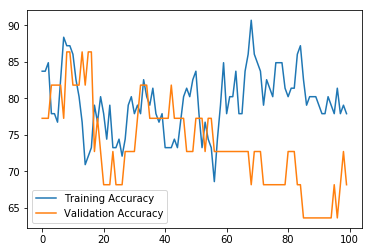

TRAIN: [  0   2   3   4   5   6   7   8   9  11  13  14  15  16  17  18  19  20
  21  22  23  24  25  27  28  29  31  32  33  34  35  36  37  38  39  40
  41  42  43  44  45  47  49  50  53  55  58  59  60  61  62  63  66  67
  68  70  71  72  73  74  75  76  78  79  80  82  83  85  86  87  88  89
  90  91  92  93  94  96  97  98  99 102 103 104 105 106] TEST: [  1  10  12  26  30  46  48  51  52  54  56  57  64  65  69  77  81  84
  95 100 101 107]
Number of training points:  (86,)
Number of testing points:  (22,)
Building Network Parameters: 
fc_units=[3000, 1000, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 10
epoch 1 
Best validation accuracy! iteration:10 accuracy: 77.27272727272728%
epoch 2 
epoch 3 
epoch 4 
Best validation accuracy! iteration:40 accuracy: 81.81818181818181%
epoch 5 
epoch 6 
Best validation accuracy! iteration:60 accuracy: 86.36363636363636%
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
ep

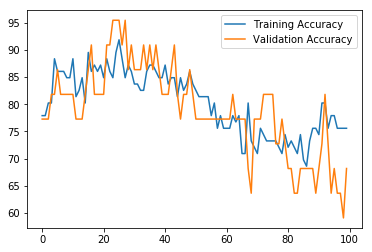

TRAIN: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  18  19
  22  23  24  25  26  28  29  30  31  32  33  36  37  38  40  41  42  43
  44  45  46  48  49  51  52  54  55  56  57  58  60  61  62  63  64  65
  66  69  71  72  73  74  76  77  80  81  83  84  85  86  88  89  90  91
  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107] TEST: [ 0 17 20 21 27 34 35 39 47 50 53 59 67 68 70 75 78 79 82 87 92]
Number of training points:  (87,)
Number of testing points:  (21,)
Building Network Parameters: 
fc_units=[3000, 1000, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 10
epoch 1 
Best validation accuracy! iteration:10 accuracy: 61.904761904761905%
epoch 2 
Best validation accuracy! iteration:20 accuracy: 71.42857142857143%
epoch 3 
epoch 4 
epoch 5 
epoch 6 
epoch 7 
epoch 8 
epoch 9 
epoch 10 
epoch 11 
epoch 12 
epoch 13 
epoch 14 
epoch 15 
epoch 16 
epoch 17 
epoch 18 
epoch 19 
epoch 20 
epoch 21 
epoch 22 
epoch 23 
epoch 24 
e

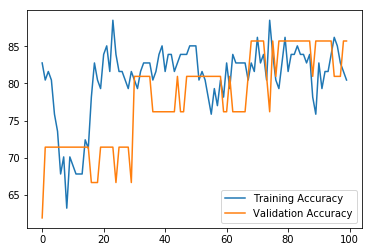

TRAIN: [  0   1   3   4   5   7   8   9  10  11  12  13  14  15  16  17  20  21
  22  26  27  30  31  32  33  34  35  36  37  38  39  40  41  42  43  46
  47  48  49  50  51  52  53  54  55  56  57  59  61  62  63  64  65  66
  67  68  69  70  71  72  73  75  77  78  79  81  82  83  84  85  87  88
  89  91  92  95  97  98  99 100 101 102 103 104 105 106 107] TEST: [ 2  6 18 19 23 24 25 28 29 44 45 58 60 74 76 80 86 90 93 94 96]
Number of training points:  (87,)
Number of testing points:  (21,)
Building Network Parameters: 
fc_units=[3000, 1000, 2]
l2_norm=0.01
seed=235
learning_rate=0.001
number of batches for training: 10
epoch 1 
Best validation accuracy! iteration:10 accuracy: 52.38095238095238%
epoch 2 
Best validation accuracy! iteration:20 accuracy: 61.904761904761905%
epoch 3 
epoch 4 
epoch 5 
Best validation accuracy! iteration:50 accuracy: 66.66666666666666%
epoch 6 
epoch 7 
epoch 8 
Best validation accuracy! iteration:80 accuracy: 71.42857142857143%
epoch 9 
epoch 10 
epoch

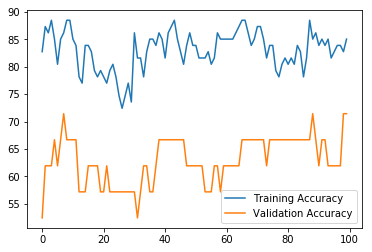

AD_MCI average accuracy is:  79.59307359307358
AD_MCI average standard deviation is:  9.858639928749263


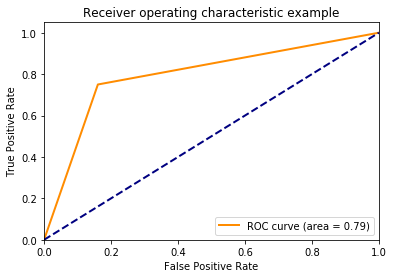

In [31]:
from sklearn.model_selection import RepeatedStratifiedKFold
from CNN_codes.CNN_with_addvariables import cnnm_training
from sklearn.metrics import roc_curve, auc

rskf=RepeatedStratifiedKFold(n_splits=5,n_repeats=5)
store_acc=[]
prediction=[]
truelabel=[]
for train_index,test_index in rskf.split(X_admci,y_admci):
    print("TRAIN:",train_index,"TEST:",test_index)
    print("Number of training points: ",train_index.shape)
    print('Number of testing points: ',test_index.shape)
    X_train,X_test=X_admci[train_index],X_admci[test_index]
    y_train,y_test=y_admci[train_index],y_admci[test_index]
    X_trainvar,X_valvar=Xvar_admci[train_index],Xvar_admci[test_index]
    tf.reset_default_graph()
    
    mask_train = np.random.choice(len(X_train),len(X_train), replace=False)
    X_train=X_train[mask_train,:,:,:]
    y_train=y_train[mask_train,]
    X_trainvar=X_trainvar[mask_train,:]
    
    record_acc,recordtrainacc,recordvalacc,roc_pred,roc_truelabel=cnnm_training(X_train,y_train,X_trainvar,X_test,y_test,X_valvar,fc_units=[3000,1000,2], 
                 conv_featmap=[6,10,16],l2_norm=0.01,seed=235,
                 learning_rate=1e-3,epoch=100,batch_size=8,imglen=164,addedvar_num=100)
    
    store_acc.append(record_acc)
    prediction.extend(roc_pred)
    truelabel.extend(roc_truelabel)
    plt.plot(recordtrainacc,label='Training Accuracy')
    plt.plot(recordvalacc,label="Validation Accuracy")
    plt.legend()
    plt.show()

mean_acc=np.mean(np.array(store_acc))
mean_std=np.std(store_acc)
print('AD_MCI average accuracy is: ',mean_acc)
print('AD_MCI average standard deviation is: ',mean_std)

fpr,tpr,_=roc_curve(prediction,truelabel)
roc_auc=auc(fpr,tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.savefig('/Users/choyale/Desktop/Deep Learning Project/Figures/ADNI_ADMCI_ROC_curve_CNNM.jpg')
plt.show()